# 依赖

In [1]:
import matplotlib.pyplot as plt
from skimage import io,data,draw,color,transform,feature
import cv2
import numpy as np
import math
from math import cos, sin, pi, tan
from mpl_toolkits.mplot3d import Axes3D
# 求解方程组
import sympy
# %matplotlib inline 

# 函数

## 功能函数

In [2]:
#对所有的空间中坐标点进行投影
#x = xc*f/zc
#y = yc*f/zc
def xyz_draw(points, name='1'):
    '''
    # 画三维点
    # points:三维点 np.array:m*3
    # name:画板名称 str
    '''
    fig = plt.figure(name)
    ax = fig.add_subplot(1,1,1, projection='3d')
    ax.scatter(points[:,0], points[:,1], points[:,2])

def xyz_projection(points, name='focal flat', draw_flag=False, f=0.03):
    '''
    # 射影变换x,y = xyz_projection()
    # points:三维点 np.array:m*3
    # name:画板名称 str
    # draw_flag:是否画图 bool
    # output：返回射影变化后的x,y
    '''
    K = np.array([[f, 0, 0],
            [0, f, 0],
            [0, 0, 1]])
    points_projection = np.dot(K, points.T)/points[:, 2].T
    x = points_projection[0,:]
    y = points_projection[1,:]
    z = np.zeros((len(x), 1)) + f
    
    if draw_flag:
        # fig = plt.figure('projection')
        # ax = fig.add_subplot(1,1,1, projection='3d')
        # ax.scatter(points[:,0], points[:,1], points[:,2])
        # ax.scatter(x, y, z)
        # for ii in range(0,len(x), 5):#画投影线
        #     ax.plot3D([points[ii, 0], x[ii]], [points[ii, 1], y[ii]], [points[ii, 2], z[ii]])
        #画焦平面
        plt.figure(name)
        plt.plot(x, y, '.r')
        plt.plot(0, 0, 'ko')
        plt.xlabel('x')
        plt.ylabel('y')
        #y轴反转，符合坐标系设定
        plt.gca().invert_yaxis() 
        plt.axis('equal')
        
    return x, y

# 旋转轴v1v2：v1(a1, b1, c1), v2(a2, b2, c2)
# 旋转角度theta
# 位移矩阵
def xyz_rotation(points, r_theta = 0, r_axis=[1, 0, 0], p1 = [0, 0, 0], name='rotation', draw_flag=False):
    '''
    获得旋转矩阵，并变化 r_theta, r_axis, points_extent_draw, RR = xyz_rotation()
    ---------------
    points:三维点 np.array:m*3
    p1:[a, b, c]起点（这里设置为[0,0,0]）
    r_theta:旋转角度 弧度 逆时针
    name:画板名称 str
    r_axis:旋转轴 [u,v,w]
    draw_flag:是否画图 bool
    ---------------
    output：返回旋转角（弧度）theta，旋转轴归一化r_axis，变化后的点points_extent_draw:m*4
    RR:np.array 4*4
    ---------------
    '''
    theta = r_theta
    points_extent = np.hstack((points, np.ones((points.shape[0],1))))
    #theta = -i/20*pi
    #[a1, b1, c1] = [125, 125, 10]
    #[a, b, c] = [1, 0, 0]
    #T1 = np.array([[1,0,0,-a1],
                  #[0,1,0,-b1],
                  #[0,0,1,-c1],
                  #[0,0,0,1]])
    #T2 = np.array([[1,0,0,a1],
                  #[0,1,0,b1],
                  #[0,0,1,c1],
                  #[0,0,0,1]])
    #R = np.array([[a**2+(1-a**2)*cos(theta), a*b*(1-cos(theta))+c*cos(theta), a*c*(1-cos(theta))-b*sin(theta), 0],
                 #[a*b*(1-cos(theta))-c*sin(theta), b**2+(1-b**2)*cos(theta), b*c*(1-cos(theta))+a*sin(theta), 0],
                 #[a*c*(1-cos(theta)+b*sin(theta)), b*c*(1-cos(theta))-a*sin(theta), c**2+(1-c**2)*cos(theta), 0],
                 #[0, 0, 0, 1]])
    if np.linalg.norm(np.array(r_axis), 2)==0:
        return -1
    else:
        #[u, v, w] = [1, 0, 0]#旋转轴，需要是单位向量
        r_axis = np.array(r_axis)/np.linalg.norm(np.array(r_axis), 2)
        [u, v, w] = r_axis
    [a, b, c] = p1[:]
    #[a, b, c] = [125, 125, 10]#第一个点，位移向量
    #[a, b, c] = [0, 0, 0]
    #theta = pi/4
    RR = np.array([[u**2+(v**2+w**2)*cos(theta), u*v*(1-cos(theta))-w*sin(theta), u*w*(1-cos(theta))+v*sin(theta), (a*(v**2+w**2)-u*(b*v+c*w))*(1-cos(theta))+(b*w-c*v)*sin(theta)],
                   [u*v*(1-cos(theta))+w*sin(theta), v**2+(u**2+w**2)*cos(theta), v*w*(1-cos(theta))-u*sin(theta), (b*(u**2+w**2)-v*(a*u+c*w))*(1-cos(theta))+(c*u-a*w)*sin(theta)],
                   [u*w*(1-cos(theta))-v*sin(theta), u*w*(1-cos(theta))+u*sin(theta), w**2+(u**2+v**2)*cos(theta), (c*(w**2+v**2)-w*(a*u+b*v))*(1-cos(theta))+(a*v-b*u)*sin(theta)],
                   [0, 0, 0, 1]])

    
    #print(RR)
    points_extent_draw = points_extent.dot(RR.T)
    #points_extent_draw1 = points_extent.dot(T1.dot(R).dot(T2))
    if draw_flag:
        fig = plt.figure(name)
        ax = fig.add_subplot(1,1,1, projection='3d')
        ax.scatter(points[:,0], points[:,1], points[:,2])
        ax.scatter(points_extent_draw[:,0], points_extent_draw[:,1], points_extent_draw[:,2])
        #ax.scatter(points_extent_draw1[:,0], points_extent_draw1[:,1], points_extent_draw1[:,2], 'b')
        ax.plot3D([a, a+u*100], [b, b+v*100], [c, c+w*100], 'r')
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('z')
    return r_theta, r_axis, points_extent_draw, RR

def xyz_getCircle(xc, yc, r, num=1000):
    '''
    # 画圆 x,y = xyz_getCircle(xc, yc, r)
    # xc:float
    # yc:float
    # r:float
    # num:点的数目
    # output:
    # x:np.array:1*m
    # y:np.array:1*m
    '''
    theta = np.linspace(0, 2*pi, num)
    x = r*np.cos(theta) + xc
    y = r*np.sin(theta) + yc
    return x, y

def xyz_ellipse_fx(theta, xe, ye, a, b, phi):
    '''
    椭圆参数方程：x = xyz_ellipse_fx()
    theta:np.array弧度集合
    xe:float
    ye:float
    a:float
    b:float
    phi:float弧度
    output:
    x:np.array
    '''
    return a*cos(phi)*np.cos(theta) - b*sin(phi)*np.sin(theta) + xe
def xyz_ellipse_fy(theta, xe, ye, a, b, phi):
    '''
    椭圆参数方程：y = xyz_ellipse_fy()
    theta:np.array弧度集合
    xe:float
    ye:float
    a:float
    b:float
    phi:float弧度
    output:
    y:np.array
    '''
    return a*sin(phi)*np.cos(theta) + b*cos(phi)*np.sin(theta) + ye
def xyz_getEllipse(xe, ye, a, b, phi, num=1000):
    '''
    x,y=xyz_getEllipse()
    xe:float
    ye:float
    a:float
    b:float
    phi:float弧度，a轴和x轴方向的倾斜角
    num:正整数 点的数目 
    output:
    x:np.array
    y:np.array
    '''
    theta = np.linspace(0, 2*pi, num)
    x = xyz_ellipse_fx(theta, xe, ye, a, b, phi)
    y = xyz_ellipse_fy(theta, xe, ye, a, b, phi)
    return x, y

def xyz_getExtremumFromEllipse(xe, ye, a, b, phi):
    '''
    获得椭圆的四个极值点 Ay, By, Ax, Bx = xyz_getExtremumFromEllipse()
    xe:float
    ye:float
    a:float
    b:float
    phi:float弧度
    output:
    四个点都是长度为2的list
    Ay, By:代表在y轴上的两个极值点,Ay.y<By.y，By点在最上方点，Ay最下方点
    Ax, Bx:代表在x轴上的两个极值点,Ax.x<Bx.x，Bx点在最右方点，Ax最左方点
    '''
    if phi==0:
        theta_x = 0
        theta_y = pi/2
    else:
        #x的极值
        theta_x = math.atan(-b*sin(phi)/(a*cos(phi)))
        #y的极值
        theta_y = math.atan( b*cos(phi)/(a*sin(phi)))
    if xyz_ellipse_fx(theta_x, xe, ye, a, b, phi)<xyz_ellipse_fx(theta_x+pi, xe, ye, a, b, phi):
        Ax_x = xyz_ellipse_fx(theta_x, xe, ye, a, b, phi)
        Ax_y = xyz_ellipse_fy(theta_x, xe, ye, a, b, phi)
        Bx_x = xyz_ellipse_fx(theta_x+pi, xe, ye, a, b, phi)
        Bx_y = xyz_ellipse_fy(theta_x+pi, xe, ye, a, b, phi)
    else:
        Ax_x = xyz_ellipse_fx(theta_x+pi, xe, ye, a, b, phi)
        Ax_y = xyz_ellipse_fy(theta_x+pi, xe, ye, a, b, phi)
        Bx_x = xyz_ellipse_fx(theta_x, xe, ye, a, b, phi)
        Bx_y = xyz_ellipse_fy(theta_x, xe, ye, a, b, phi)

    if xyz_ellipse_fy(theta_y, xe, ye, a, b, phi)<xyz_ellipse_fy(theta_y+pi, xe, ye, a, b, phi):
        Ay_x = xyz_ellipse_fx(theta_y, xe, ye, a, b, phi)
        Ay_y = xyz_ellipse_fy(theta_y, xe, ye, a, b, phi)
        By_x = xyz_ellipse_fx(theta_y+pi, xe, ye, a, b, phi)
        By_y = xyz_ellipse_fy(theta_y+pi, xe, ye, a, b, phi)
    else:
        Ay_x = xyz_ellipse_fx(theta_y+pi, xe, ye, a, b, phi)
        Ay_y = xyz_ellipse_fy(theta_y+pi, xe, ye, a, b, phi)
        By_x = xyz_ellipse_fx(theta_y, xe, ye, a, b, phi)
        By_y = xyz_ellipse_fy(theta_y, xe, ye, a, b, phi)
    Ax = [Ax_x, Ax_y]
    Bx = [Bx_x, Bx_y]
    Ay = [Ay_x, Ay_y]
    By = [By_x, By_y]
    return Ay, By, Ax, Bx

## 计算函数

### 圆旋转获得任意位姿的圆

In [3]:
def xyz_rotation_circle(points, N=np.array([0, 0, 1]), name='rotation', draw_flag=False):
    '''
    ---------------
    points, n, Rx, Ry = xyz_rotation_circle()
    points = RxRy*points
    ---------------
    input:
    N：平面法向量：np.array:[a, b, c]
    points：xoy平面上的圆：np.array()：m*3
    ---------------
    output:
    n：法向量：单位化后:np.array
    points:np.array():m*3
    ---------------
    '''
    # 归一化
    n = np.array(N)/np.linalg.norm(N, 2)
    [a, b, c] = n
    # 求得n确定的两个旋转角
    if b==0 and c==0:#当法线方向是x轴时
        cosa = 1
        sina = 0
    else:
        cosa = c/(np.sqrt(b**2+c**2))
        sina = b/(np.sqrt(b**2+c**2))
    cosb = np.sqrt(b**2+c**2)
    sinb = a
    # 求得两个旋转矩阵 反变换 X = (Rx*Ry)*(Ry'*Rx'*X)
    # X' = Ry'*Rx'*X
    # X = Rx*Ry*X'
    # Rx' = np.array([[1, 0, 0], 
    #                [0, cosa, -sina], 
    #                [0, sina, cosa]])
    # Ry' = np.array([[cosb, 0, -sinb], 
    #                [0, 1, 0], 
    #                [sinb, 0, cosb]])
    Rx = np.array([[1, 0, 0], 
                   [0, cosa, sina], 
                   [0, -sina, cosa]])
    Ry = np.array([[cosb, 0, sinb], 
                   [0, 1, 0], 
                   [-sinb, 0, cosb]])
    R_points_draw = np.dot(Rx, np.dot(Ry, points.T)).T
    if draw_flag:
        fig = plt.figure(name)
        ax = fig.add_subplot(1,1,1, projection='3d')
        ax.plot3D([0, a*0.5], [0, b*0.5], [0, c*0.5], 'r', label='normal')
        ax.scatter(points[:,0], points[:,1], points[:,2], label='cirlce')
        ax.scatter(R_points_draw[:,0], R_points_draw[:,1], R_points_draw[:,2], label='rotation')
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('z')
        ax.legend(loc=1)
    return R_points_draw, n, Rx, Ry

<IPython.core.display.Javascript object>


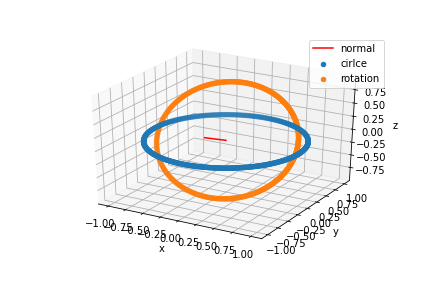

<IPython.core.display.Javascript object>


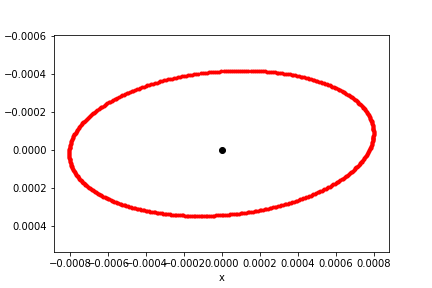

<IPython.core.display.Javascript object>


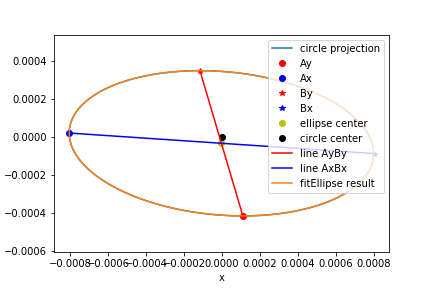

In [46]:
plt.switch_backend('nbAgg')
radius = 1
Pc = [0, 0, 10]
#Normal = [1, 0, 0]
Normal = np.random.randn(3)
f = 0.008
#在z=0的空间平面上画圆，获得以(0, 0)为圆心坐标，60为半径的圆
r = radius
#初始圆心在原点处
xc, yc, zc = 0, 0, 0
x, y = xyz_getCircle(xc, yc, r, num=500)
#获得物方点points
points = np.zeros((len(x), 3))
points[:, 0] = x
points[:, 1] = y
points[:, 2] = 0
#将空间的点绕轴旋转
#r_theta, r_axis, r_points, RR = xyz_rotation(points, r_theta=r_theta, r_axis=r_axis, draw_flag=draw_flag)
r_points_draw, N, Rx, Ry = xyz_rotation_circle(points, N=Normal, name='rotation_circle', draw_flag=True)
#平移到圆心处
r_points = r_points_draw.copy()
xc, yc, zc = Pc[:]
r_points[:, 0] += xc
r_points[:, 1] += yc
r_points[:, 2] += zc
#焦平面成像
ff_x, ff_y = xyz_projection(r_points[:, 0:3], 'focal falt', draw_flag=True, f=f)
#圆中心投影
ff_xc, ff_yc = xyz_projection(np.array(Pc).reshape((1,3)), f=f)
#找到焦平面上的椭圆
e_center, e_axes, e_angle = xyz_fitEllipse(ff_x, ff_y)
#e_angle = e_angle*pi/180
#找到拟合椭圆的极值
Ay, By, Ax, Bx = xyz_getExtremumFromEllipse(e_center[0], e_center[1], e_axes[0]/2, e_axes[1]/2, e_angle)
if True:
    xyz_showResult(e_center, e_axes, e_angle, ff_x, ff_y, ff_xc, ff_yc, Ay, By, Ax, Bx, name='normal is {}'.format(N))
plt.show()

### 最小二乘法拟合椭圆

In [4]:
def xyz_fitEllipse(x, y, fitStyle=0, scal=10000):
    '''
    #center, axes, angle = xyz_fitEllipse(x, y)
    #x:np.array:1*m
    #y:np.array:1*m
    #fitStyle:0:最小二乘法拟合
    #fitStyle:1:cv.fitEllipse()
    #scal：正整数，当fitStyle=1时有用
    #output:
    #center：list 椭圆中心
    #axes:list 长短轴的二倍
    #angle:float 弧度（逆时针）
    '''
    # 最小二乘法拟合
    if fitStyle==0:
        from scipy.optimize import leastsq
        def xyz_leastSQ_fitEllipse(x, y):#使用最小二乘，确定系数
            '''
            # a*x^2 + b*x*y + c*y^2 + d*x + e*y + f = 0
            # f = 1
            # [a, b, c, d, e]*[x^2, x*y, y^2, x, y] = -1
            '''
            Y = np.ones(x.shape)*-1
            # 需要拟合的函数
            def fit_func(p, x, y):
                a,b,c,d,e = p
                return a*x**2+b*x*y+c*y**2+d*x+e*y
            # 误差函数
            def error(p, x, y, Y):
                return fit_func(p, x, y) - Y
            p0 = [0, 0, 0, 0, 0]
            paras = leastsq(error, p0, args=(x, y, Y))
            [A, B, C, D, E] = paras[0][:]
            return [A, B, C, D, E, 1]
        
        def xyz_solve_ellipse(x,y):#没有明白具体过程，功能是获得椭圆的系数
            '''
            #x,y:np.arrayfrom scipy.optimize import leastsq
            #a*x**2 + b*x*y + c*y**2 + d*x + e*y + f
            '''
            # x0, y0：椭圆中心
            x0, y0 = x.mean(), y.mean()      
            # 做线性拟合
            D1 = np.array([(x-x0)**2, (x-x0)*(y-y0), (y-y0)**2]).T
            D2 = np.array([x-x0, y-y0, np.ones(y.shape)]).T
            S1 = np.dot(D1.T, D1)
            S2 = np.dot(D1.T, D2)
            S3 = np.dot(D2.T, D2)    
            T = -1*np.dot(np.linalg.inv(S3), S2.T)
            M = S1 + np.dot(S2, T)
            M = np.array([M[2]/2, -M[1], M[0]/2])
            lam, eigen = np.linalg.eig(M)
            cond = 4*eigen[0]*eigen[2]-eigen[1]**2
            A1 = eigen[:, cond>0] 
            A = np.vstack([A1, np.dot(T, A1)]).flatten()
            A3 = A[3]-2*A[0]*x0-A[1]*y0
            A4 = A[4]-2*A[2]*y0-A[1]*x0
            A5 = A[5]+A[0]*x0**2+A[2]*y0**2+A[1]*x0*y0-A[3]*x0-A[4]*y0
            A[3] = A3
            A[4] = A4
            A[5] = A5
            return A
        
        def xyz_normal_style(paras):
            '''
            #paras = [a, b, c, d, f]
            #a*x**2 + b*x*y + c*y**2 + d*x + e*y + f
            #print('计算标准椭圆位置.....')
            #solve_tuoyuan.return A
            '''
            paras = paras/paras[5]
            A,B,C,D,E,F = paras[:6]
            #椭圆中心    
            x0 = (B*E-2*C*D)/(4*A*C-B**2)
            y0 = (B*D-2*A*E)/(4*A*C-B**2)
            #长短轴
            a = 2*np.sqrt((2*A*(x0**2)+2*C*(y0**2)+2*B*x0*y0-2)/(A+C+np.sqrt(((A-C)**2+B**2))))
            b = 2*np.sqrt((2*A*(x0**2)+2*C*(y0**2)+2*B*x0*y0-2)/(A+C-np.sqrt(((A-C)**2+B**2))))
            #轴倾角为a轴与x轴的夹角
            F = 1/(A*(x0**2)+C*(y0**2)+B*x0*y0-1)
            a_b_flag = -1 if a>b else 1
            flag = F*a_b_flag*B
            if False:
                print('-F is {}'.format(F))
                print('-a_b_flag is {}'.format(a_b_flag))
                print('-phi flag is {}'.format(flag))
            if A==C:#当A==C时，倾斜角的值为pi/4，tan(pi/2)接近于无穷，此时有估计误差
                #print('-0 A dengyu C!')
                q = pi/4 if flag>0 else -pi/4
            else:#考虑到arctan(B/(A-C))=arctan(2*phi)解的范围为[-pi/2, pi/2]，而倾斜角phi范围为[-pi/2, pi/2]
                #对应2*phi的范围为[-pi, pi]，arctan(2*phi)解在此区间有两个解，需要依靠flag的正负性来确定唯一解
                #flag取决于B，B=B/F=2*cos(phi)*sin(phi)*(1/a**2 - 1/b**2)
                #a,b计算出来的值可信，flag~sin(phi)~B*F*(1/a**2-1/b**2)
                q = 0.5 * np.arctan(B/(A-C))
                if flag>0 and q<0:#说明phi[0, pi/2], 2*phi[0, pi], 计算的tan(2*phi)<0, 说明对应在[0, pi]区间为pi+2*phi
                    q = (pi+2*q)/2
                if flag<0 and q>0:#同上
                    q = (2*q-pi)/2
                if np.abs(np.abs(q)-pi/4)<10e-8:#当A==C时，倾斜角的值为pi/4，tan(pi/2)接近于无穷，此时有估计误差
                    #print('-1 A dengyu C!')
                    q = pi/4 if flag>0 else -pi/4       
            if False:#进行验算
                p = q
                print('paras is: ', paras[:])
                A = (cos(p)**2)/(a**2) + (sin(p)**2)/(b**2)
                B = 2*cos(p)*sin(p)*(1/(a**2) - 1/(b**2))
                C = (sin(p)**2)/(a**2) + (cos(p)**2)/(b**2)
                D = -2*A*x0 - B*y0
                E = -2*C*y0 - B*x0
                F = A*(x0**2) + C*(y0**2) + B*x0*y0 - 1
                print('paras is: ', [A,B,C,D,E,F])
                print('paras is: ', [A,B,C,D,E,F]/F)
            return [x0, y0], [a, b], q
        #使用最小二乘法拟合椭圆
        #print(xyz_leastSQ_fitEllipse(x, y)[:])
        return xyz_normal_style(xyz_solve_ellipse(x, y))
        #return xyz_leastSQ_fitEllipse(x, y)
    
    #cv.Ellipse
    #points类型要求是numpy.array（[[[x,y]],[[x1,y1]]...]） 并不是把所有点都包括在椭圆里面，而是拟合出一个椭圆尽量使得点都在圆上
    #points类型需要是int32的
    points_focalFlat = np.zeros((len(x), 1, 2), dtype=int)
    #将所有的点放大scal倍，然后除以scal倍
    points_focalFlat[:,0, 0] = [int(i*scal) for i in x]
    points_focalFlat[:,0, 1] = [int(i*scal) for i in y]
    #找到图像中的椭圆
    ellipse = cv2.fitEllipse(points_focalFlat)
    #ellipse的焦平面坐标默认乘上scal倍
    #中心
    center = [ellipse[0][0]/scal, ellipse[0][1]/scal]
    #长短轴的二倍
    axes = [ellipse[1][0]/scal, ellipse[1][1]/scal]
    #旋转角度（逆时针）
    angle = ellipse[2]*pi/180
    
    return center, axes, angle

<IPython.core.display.Javascript object>


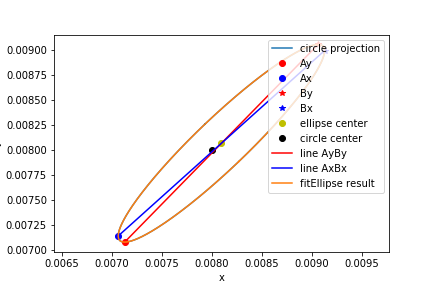

[0.0080930279547790328, 0.0080699159306999273] [0.00050431355844174396, 0.0028131116949621582] -46.3113609377


In [47]:
f=0.008
radius = 1
#r_theta = 18*pi/180
r_theta = np.random.random()*pi
r_axis = [np.random.random()-0.5, np.random.random()-0.5, np.random.random()-0.5]
r = radius
Pc = [10, 10, 10]
draw_flag=False
#初始圆心在原点处
xc, yc, zc = 0, 0, 0
x, y = xyz_getCircle(xc, yc, r, num=500)
#获得物方点points
points = np.zeros((len(x), 3))
points[:, 0] = x
points[:, 1] = y
points[:, 2] = zc
#将空间的点绕轴旋转
r_theta, r_axis, r_points, RR = xyz_rotation(points, r_theta=r_theta, r_axis=r_axis, draw_flag=False)
#平移到圆心处
xc, yc, zc = Pc[:]
r_points[:, 0] += xc
r_points[:, 1] += yc
r_points[:, 2] += zc
#焦平面成像
ff_x, ff_y = xyz_projection(r_points[:, 0:3], 'focal falt', draw_flag=draw_flag, f=f)
#圆中心投影
ff_xc, ff_yc = xyz_projection(np.array(Pc).reshape((1,3)), f=f)
scal = 30000
e_center, e_axes, e_angle = xyz_fitEllipse(ff_x, ff_y, fitStyle=0, scal=scal)
Ay, By, Ax, Bx = xyz_getExtremumFromEllipse(e_center[0], e_center[1], e_axes[0]/2, e_axes[1]/2, e_angle)
xyz_showResult(e_center, e_axes, e_angle, ff_x, ff_y, ff_xc, ff_yc, Ay, By, Ax, Bx, name='r_theta is ' + str(r_theta*180/pi) + '°')
plt.show()
print(e_center, e_axes, e_angle*180/pi)

### 数据生成，模拟成像，拟合椭圆过程

圆法线方式 vs 轴角方式

In [5]:
def xyz_getRelationDataFromNormal(f = 8*1e-3, Pc=[0, 0, 10], radius=1, Normal=[1, 1, 1], draw_flag=False, draw_result=False):
    '''
    f, Pc, radius, Normal, [ff_xc, ff_yc], [Ay, By, Ax, Bx], e_center, e_axes, e_angle
    = xyz_getRelationDataFromNormal()
    -已知f, radius, Pc, Normal, 生成空间中的圆，并进行成像
    #input
    #相机焦距f:float
    #圆中心坐标Pc:list:[xc, yc, zc]
    #圆半径radius:float
    #draw_flag:plot圆成像过程
    #draw_result:plot拟合椭圆结果
    #output
    #相机焦距f:float
    #圆中心坐标Pc:list:[xc, yc, zc]
    #圆半径radius:float
    #发现方向Normal：[a,b,c]
    #圆中心在焦平面射影：[ff_xc, ff_yc]:list
    #四个极值点：Ay, By, Ax, Bx
            Ay, By:代表在y轴上的两个极值点,Ay.y<By.y，By点在最上方点，Ay最下方点
            Ax, Bx:代表在x轴上的两个极值点,Ax.x<Bx.x，Bx点在最右方点，Ax最左方点
    #焦平面椭圆圆心：e_center:list:[xe, ye]
    #焦平面椭圆长短轴：e_axes:list:[a, b]
    #焦平面椭圆倾斜角：e_angle:float:弧度（逆时针旋转）
    '''
    #在z=0的空间平面上画圆，获得以(0, 0)为圆心坐标，60为半径的圆
    r = radius
    #初始圆心在原点处
    xc, yc, zc = 0, 0, 0
    x, y = xyz_getCircle(xc, yc, r, num=500)
    #获得物方点points
    points = np.zeros((len(x), 3))
    points[:, 0] = x
    points[:, 1] = y
    points[:, 2] = 0
    #将空间的点按照法线方向旋转
    r_points_draw, Normal, Rx, Ry = xyz_rotation_circle(points, N=Normal, name='rotation_circle', draw_flag=draw_flag)
    #平移到圆心处
    r_points = r_points_draw.copy()
    xc, yc, zc = Pc[:]
    r_points[:, 0] += xc
    r_points[:, 1] += yc
    r_points[:, 2] += zc
    #焦平面成像
    ff_x, ff_y = xyz_projection(r_points[:, 0:3], 'focal falt', draw_flag=draw_flag, f=f)
    #圆中心投影
    ff_xc, ff_yc = xyz_projection(np.array(Pc).reshape((1,3)), f=f)
    #找到焦平面上的椭圆
    e_center, e_axes, e_angle = xyz_fitEllipse(ff_x, ff_y)
    #e_angle = e_angle*pi/180
    #找到拟合椭圆的极值
    Ay, By, Ax, Bx = xyz_getExtremumFromEllipse(e_center[0], e_center[1], e_axes[0]/2, e_axes[1]/2, e_angle)
    if draw_result:
        xyz_showResult(e_center, e_axes, e_angle, ff_x, ff_y, ff_xc, ff_yc, Ay, By, Ax, Bx, name='normal is {}'.format(Normal))
    
    return f, Pc, radius, Normal, [ff_xc, ff_yc], [Ay, By, Ax, Bx], e_center, e_axes, e_angle

def xyz_getRelationData(f = 30*1e-3, Pc=[100, 100, 100], radius=60, r_axis=[1, 1, 0], r_theta=0*pi/180, draw_flag=False, draw_result=False, scal=10000):
    '''
    f, Pc, radius, r_axis, r_theta, RR, [ff_xc, ff_yc], [Ay, By, Ax, Bx], e_center, e_axes, e_angle
    = xyz_getRelationData()
    -已知f, radius, Pc, r_axis, r_theta, 生成空间中的圆，并进行成像
    -拟合椭圆时需要注意，使用的是cv.fitellipse()，需要拟合点是整数，为了保证精度问题，xyz_fitEllipse(ff_x, ff_y, scal=10000)
    -可以更改scal, 值越大精度越大
    #input
    #相机焦距f:float
    #圆中心坐标Pc:list:[xc, yc, zc]
    #圆半径radius:float
    #旋转轴r_axis:list:[u, v, w]
    #旋转角度r_theta:float:弧度（逆时针旋转）
    #draw_flag:plot圆成像过程
    #draw_result:plot拟合椭圆结果
    #scal:拟合椭圆参数
    #output
    #相机焦距f:float
    #圆中心坐标Pc:list:[xc, yc, zc]
    #圆半径radius:float
    #旋转轴r_axis:list:[u, v, w]
    #旋转角度r_theta:float:弧度（逆时针旋转）
    #旋转矩阵：RR:np.array:3*3 (RR=f(r_axis, r_theta))
    #圆中心在焦平面射影：[ff_xc, ff_yc]:list
    #四个极值点：Ay, By, Ax, Bx
            Ay, By:代表在y轴上的两个极值点,Ay.y<By.y，By点在最上方点，Ay最下方点
            Ax, Bx:代表在x轴上的两个极值点,Ax.x<Bx.x，Bx点在最右方点，Ax最左方点
    #焦平面椭圆圆心：e_center:list:[xe, ye]
    #焦平面椭圆长短轴：e_axes:list:[a, b]
    #焦平面椭圆倾斜角：e_angle:float:弧度（逆时针旋转）
    '''
    #空间中的圆
    #f = 30*1e-3
    #du = 12e-4#像元尺寸
    #在z=0的空间平面上画圆，获得以(0, 0)为圆心坐标，60为半径的圆
    r = radius
    #初始圆心在原点处
    xc, yc, zc = 0, 0, 0
    x, y = xyz_getCircle(xc, yc, r, num=500)
    #获得物方点points
    points = np.zeros((len(x), 3))
    points[:, 0] = x
    points[:, 1] = y
    points[:, 2] = zc
    #将空间的点绕轴旋转
    r_theta, r_axis, r_points_draw, RR = xyz_rotation(points, r_theta=r_theta, r_axis=r_axis, draw_flag=draw_flag)
    #平移到圆心处
    r_points = r_points_draw.copy()
    xc, yc, zc = Pc[:]
    r_points[:, 0] += xc
    r_points[:, 1] += yc
    r_points[:, 2] += zc
    #焦平面成像
    ff_x, ff_y = xyz_projection(r_points[:, 0:3], 'focal falt', draw_flag=draw_flag, f=f)
    #圆中心投影
    ff_xc, ff_yc = xyz_projection(np.array(Pc).reshape((1,3)), f=f)
    #找到焦平面上的椭圆
    e_center, e_axes, e_angle = xyz_fitEllipse(ff_x, ff_y, scal=scal)
    #e_angle = e_angle*pi/180
    #找到拟合椭圆的极值
    Ay, By, Ax, Bx = xyz_getExtremumFromEllipse(e_center[0], e_center[1], e_axes[0]/2, e_axes[1]/2, e_angle)
    if draw_result:
        xyz_showResult(e_center, e_axes, e_angle, ff_x, ff_y, ff_xc, ff_yc, Ay, By, Ax, Bx, name='r_theta is ' + str(r_theta*180/pi) + '°')
    return f, Pc, radius, r_axis, r_theta, RR, [ff_xc, ff_yc], [Ay, By, Ax, Bx], e_center, e_axes, e_angle

# 拟合椭圆结果显示
def xyz_showResult(e_center, e_axes, e_angle, ff_x, ff_y, ff_xc, ff_yc, Ay, By, Ax, Bx, name='ellipse'):
    '''
    xyz_showResult(e_center, e_axes, e_angle, ff_x, ff_y, ff_xc, ff_yc, Ay, By, Ax, Bx)
    -显示生成空间圆数据，旋转后，到焦平面投影，焦平面成像拟合椭圆，这一系过程结果
    -如果只生成两个椭圆重叠，说明拟合成功，如果不成功，说明拟合欠佳
    #焦平面椭圆圆心：黑色点：e_center:list:[xe, ye]
    #焦平面椭圆长短轴：e_axes:list:[a, b]
    #焦平面椭圆倾斜角：e_angle:float:弧度（逆时针旋转）
    #焦平面上的点：ff_x, ff_y:np.array:1*m
    #圆中心在焦平面射影：ff_xc, ff_yc:float
    #四个极值点：Ay, By, Ax, Bx（y轴极值点连线，红线，x轴极值点连线，蓝线）
    #空间圆绕着某轴的旋转角度：name:str(角度)
    '''
    xx, yy = xyz_getEllipse(e_center[0], e_center[1], e_axes[0]/2, e_axes[1]/2, e_angle, num=1000)
    plt.figure(name)
    plt.plot(ff_x, ff_y, label='circle projection')
    plt.plot(Ay[0], Ay[1], 'ro', label='Ay')
    plt.plot(Ax[0], Ax[1], 'bo', label='Ax')
    plt.plot(By[0], By[1], 'r*', label='By')
    plt.plot(Bx[0], Bx[1], 'b*', label='Bx')
    plt.plot(e_center[0], e_center[1], 'yo', label='ellipse center')
    plt.plot(ff_xc, ff_yc, 'ko', label='circle center')
    plt.plot([Ay[0], By[0]], [Ay[1], By[1]], 'r', label='line AyBy')
    plt.plot([Ax[0], Bx[0]], [Ax[1], Bx[1]], 'b', label='line AxBx')
    plt.plot(xx, yy, label='fitEllipse result')
    plt.legend(loc=1)
    ##plt.axis([-0.01, 0.08, -0.01, 0.08], 'equal')
    #my_x_ticks = np.arange(-0.01, 0.09, 0.01)
    #my_y_ticks = np.arange(-0.01, 0.09, 0.01)
    #plt.xticks(my_x_ticks)
    #plt.yticks(my_y_ticks)
    plt.axis('equal')
    plt.xlabel('x')
    plt.ylabel('y')

### 获得直线

In [6]:
def xyz_getLine(xo, yo, gamma, num=10, length=1):
    '''
    x,y = xyz_getLine()
    ---------------
    点斜式画线，num点数，length,x线长度的2倍
    需要使用到numpy, math
    import numpy as np
    from math import pi
    ---------------
    input:
    xo,yo:线上一点:float
    gamma:倾斜角:float[0-pi]:弧度
    ---------------
    output:
    x:np.array:10*1:x = np.arange(xo-length, xo+length, length/num)
    y:np.array:10*1
    ---------------
    '''
    if gamma>=0 and gamma<=pi:
        # 点斜式方程
        x = np.arange(xo-length, xo+length, length/num)
        # 点斜式，当gamma=pi/2时，y值需要特殊考虑
        if gamma==pi/2:
            y = np.arange(yo-length, yo+length, length/num)
            x = np.zeros(y.shape) + xo
        else:
            y = (x-xo)*np.tan(gamma) + yo
        return x, y
    else:
        print('error:gamma 范围必须要在[0, pi]内！')
        return None, None

### 求解直线和椭圆交点

${\frac{(x-xe)^{2}}{a^{2}} + \frac{(y-ye)^{2}}{b^{2}} = 1}$  
${\frac{(cos(\phi)*(x^{'}-xe) + sin(\phi)*(y^{'}-ye))^{2}}{a^{2}} + \frac{(- sin(\phi)*(x^{'}-xe) + cos(\phi)*(y^{'}-ye))^{2}}{b^{2}} = 1}$  

In [7]:
def xyz_calcIntersectionOfLineAndEllipse(xo, yo, gamma, xe, ye, a, b, phi):
    '''
    [ax, ay], [bx, by] = xyz_calcIntersectionOfLineAndEllipse()
    ------------------
    计算线和椭圆的两个交点，求解方程的形式
    需要使用sympy库进行计算
    ------------------
    input:
    line:点斜式：xo,yo,gamma:float
    ellipse:标准方程：xe,ye,a,b,phi:float
    ------------------
    output:
    ax,ay:float
    bx,by:float
    (ay>by)，如果ay=by，则ax>bx
    ------------------
    '''
    x, y = sympy.symbols('x, y')
    if gamma==pi/2:
        # 平行于y轴的直线,直接将x=xo作为约束即可
        result = sympy.solve([x-xo, (cos(phi)*(x-xe)+sin(phi)*(y-ye))**2/(a**2) + \
                             (-sin(phi)*(x-xe)+cos(phi)*(y-ye))**2/(b**2)-1], [x, y])
    else:
        result = sympy.solve([(x-xo)*tan(gamma)+yo-y, (cos(phi)*(x-xe)+sin(phi)*(y-ye))**2/(a**2) + \
                             (-sin(phi)*(x-xe)+cos(phi)*(y-ye))**2/(b**2)-1], [x, y])
    if len(result)!=2:
        print('error：解的个数少于两个！')
        return result
    else:
        [(ax, ay), (bx, by)] = result
        if ay<by:
            ax, bx = bx, ax
            ay, by = by, ay
        if ay==by and ax<bx:
            ax, bx = bx, ax
            ay, by = by, ay
    # 这里由于返回的值是tuple，转为float
    return [float(ax), float(ay)], [float(bx), float(by)]

### 同心圆成像，两个椭圆确定圆投影中心ff_xc, ff_yc

In [28]:
def xyz_calc_ffxcffycFromConcentricCircles(ellipse1, ellipse2, R, r, ff_xc=0, ff_yc=0, plot_Flag=False):
    '''
    [u0, v0] = xyz_calc_ffxcffycFromConcentricCircles()
    ----------------
    input:
    ellipse1: 外圆椭圆：[xe1, ye1, a1, b1, phi1]
    ellipse2: 内圆椭圆：[xe2, ye2, a2, b2, phi2]
    - 注意，这里a1,b1,a2,b2为长短轴的一半
    R, r: 外圆半径，内圆半径
    [ff_xc, ff_yc]=[0,0]:用于验证，输入圆投影中心准确值
    plot_Flag=False：是否显示
    ----------------
    output:
    [u0, v0]
    ---------------
    '''
    # 计算椭圆中心斜线斜率p1p2
    [xe1, ye1, a1, b1, phi1] = ellipse1
    [xe2, ye2, a2, b2, phi2] = ellipse2
    gamma = np.arctan((ye2-ye1)/(xe2-xe1))
    # 求交点
    [ax1, ay1], [bx1, by1] = xyz_calcIntersectionOfLineAndEllipse(xe1, ye1, gamma, xe1, ye1, a1, b1, phi1)
    [ax2, ay2], [bx2, by2] = xyz_calcIntersectionOfLineAndEllipse(xe1, ye1, gamma, xe2, ye2, a2, b2, phi2)
    # 使用交比求得四个可能的解
    # 已知四个交点(a1,b1,a2,b2), r, R(a点总在b的上方或者右方)
    # 求解圆中心投影ff_xc, ff_yc
    def xyz_calc_ffxcffycFromcrossRatio(x1, x2, x3, xx1, xx2, xx3, xx0=0):
        '''
        [u0, v0] = xyz_calc_ffxcffycFromcrossRatio()
        知道空间共线4点，和其中射影变换共线3点，计算射影变换另外一点坐标
        ----------------
        input:
        x1, x2, x3:[u, v]:射影变换三点
        xx0, xx1, xx2, xx3：空间共线4点，默认xx0对应直线的0点
        ----------------
        output:
        xx0对应的射影变化横纵坐标
        [u0, v0]
        ----------------
        '''
        u1, v1 = x1
        u2, v2 = x2
        u3, v3 = x3
        crossRatio = ((xx0-xx1)*(xx2-xx3))/((xx0-xx2)*(xx1-xx3))
        # crossRatio = ((u0-u1)*(u2-u3))/((u0-u2)*(u1-u3))
        tmp_u = crossRatio*(u1-u3)/(u2-u3)
        tmp_v = crossRatio*(v1-v3)/(v2-v3)
        u0 = (u1 - tmp_u*u2)/(1 - tmp_u)
        v0 = (v1 - tmp_v*v2)/(1 - tmp_v)
        return [u0, v0]
    # r, R = radius1, radius2
    x1, xx1 = [bx1, by1], -R
    x2, xx2 = [bx2, by2], -r
    x3, xx3 = [ax2, ay2], r
    x4, xx4 = [ax1, ay1], R
    # 从(x1, x2, x3, x4)中取三点能计算一个解 
    # (x1,x2,x3)
    [u01, v01] = xyz_calc_ffxcffycFromcrossRatio(x1, x2, x3, xx1, xx2, xx3)
    # (x1,x2,x4)
    [u02, v02] = xyz_calc_ffxcffycFromcrossRatio(x1, x2, x4, xx1, xx2, xx4)
    # (x1,x3,x4)
    [u03, v03] = xyz_calc_ffxcffycFromcrossRatio(x1, x3, x4, xx1, xx3, xx4)
    # (x2,x3,x4) 
    [u04, v04] = xyz_calc_ffxcffycFromcrossRatio(x2, x3, x4, xx2, xx3, xx4)
    [u0, v0] = [(u01+u02+u03+u04)/4, (v01+v02+v03+v04)/4]
    # plot
    if plot_Flag:
        plt.figure()
        x, y = xyz_getEllipse(xe1, ye1, a1, b1, phi1)
        plt.plot(x, y, label='ellipse1')
        x, y = xyz_getEllipse(xe2, ye2, a2, b2, phi2)
        plt.plot(x, y, label='ellipse2')
        plt.plot(ff_xc, ff_yc, 'ko', label='origin')
        plt.plot(u0, v0, 'ro', label='pridict circle center')
        plt.plot(ax1, ay1, 'o', label='a1')
        plt.plot(bx1, by1, 'o', label='b1')
        plt.plot(ax2, ay2, 'o', label='a2')
        plt.plot(bx2, by2, 'o', label='b2')
        plt.plot([ax1, bx1], [ay1, by1])
        plt.plot(xe1, ye1, 'o', label='ellipse1 center')
        plt.plot(xe2, ye2, 'o', label='ellipse2 center')
        plt.legend(loc=1)
    return [u0, v0]

<IPython.core.display.Javascript object>


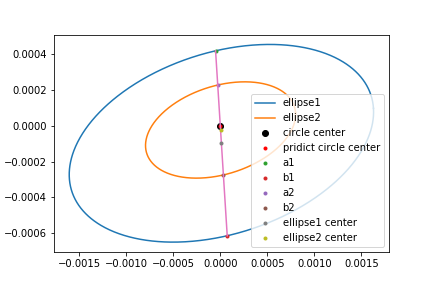

[ 0.] [ 0.]
1.0149882986268345e-19 6.745873566385445e-20


In [48]:
f=0.008; Pc=[0, 0, 10]; radius1=2; radius2=1
Normal=np.random.randn(3)
f, Pc, radius, Normal, [ff_xc, ff_yc], [Ay, By, Ax, Bx], e_center1, e_axes1, e_angle1 = \
xyz_getRelationDataFromNormal(f=f, Pc=Pc, radius=radius1, Normal=Normal)
f, Pc, radius, Normal, [ff_xc, ff_yc], [Ay, By, Ax, Bx], e_center2, e_axes2, e_angle2 = \
xyz_getRelationDataFromNormal(f=f, Pc=Pc, radius=radius2, Normal=Normal)
R, r = radius1, radius2
ellipse1 = [e_center1[0], e_center1[1], e_axes1[0]/2, e_axes1[1]/2, e_angle1]
ellipse2 = [e_center2[0], e_center2[1], e_axes2[0]/2, e_axes2[1]/2, e_angle2]
[u0, v0] = xyz_calc_ffxcffycFromConcentricCircles(ellipse1, ellipse2, R, r, ff_xc=ff_xc, ff_yc=ff_yc, plot_Flag=True)
plt.show()
print(ff_xc, ff_yc)
print(u0, v0)

### 求解过圆心投影线对应空间中的一点

In [9]:
def xyz_calcCircleCenterAndAPoint(ff_xc, ff_yc, xe, ye, a, b, phi, gamma=0, f=0.03, radius=60, show_message=False):
    '''
    [xc, yc, zc], [xa, ya, za], voa, vob, voc, phi = xyz_calcCircleCenterAndAPoint()
    -----------------
    已知圆半径radius，相机焦距f，圆中心投影C'(ff_xc, ff_yc)，
    圆射影椭圆5个参数(xe, ye, a, b, phi)，
    过C'中心的直线倾斜角gamma(和x轴正方向的夹角0-pi)，逆时针，弧度;
    求AC = line(C', gamma)对应的圆中心，和圆上一点A
    ----------------
    input:
    ff_xc, ff_yc:圆中心射影坐标：float
    xe,ye,a,b,phi：椭圆五个参数(a,b是长短轴的一半，phi是倾斜角，逆时针，弧度):float
    gamma：过C’中心的直线倾斜角，逆时针，弧度:float
    ----------------
    output:
    [xc, yc, zc]:圆中心坐标:float
    [xa, ya, za]:AC = line(C', gamma),A的坐标:float
    phi:CB和Z轴的夹角：弧度：float：取值范围[0, pi/2]
    -old:phi:CB和xoy平面的夹角：弧度：float
    ----------------
    '''
    # 获得过C‘，倾斜角为gamma的直线和椭圆的交点
    # Ay>By; Ay==By,Ax>Bx
    [Ax, Ay], [Bx, By] = xyz_calcIntersectionOfLineAndEllipse(ff_xc, ff_yc, gamma, xe, ye, a, b, phi)
    # 论文中的A，B点在光心C的左像平面上，模拟成像在右像平面上，A，B两点正好关于关心C对称
    Ax, Ay, Bx, By = Bx, By, Ax, Ay
    
    # 获得Intrinsic matrix（内参矩阵）
    K = np.array([[f, 0, 0],
                 [0, f, 0],
                 [0, 0, 1]])

    # 式(1)，求三个向量在空间中的直线方向向量
    voa = np.dot(np.linalg.inv(K), np.array([Ax, Ay, 1]))
    voa = voa/np.linalg.norm(voa, 2)
    vob = np.dot(np.linalg.inv(K), np.array([Bx, By, 1]))
    vob = vob/np.linalg.norm(vob, 2)
    voc = np.dot(np.linalg.inv(K), np.array([float(ff_xc), float(ff_yc), 1]))
    voc = voc/np.linalg.norm(voc, 2)
    if show_message:
        print('- 三个向量：')
        print(voa)
        print(vob)
        print(voc)

    # 式(2,3)，求解两个theta角
    theta1 = math.acos(np.dot(voa, voc))
    theta2 = math.acos(np.dot(vob, voc))
    if show_message:
        print('- 两个theta角度：')
        print(theta1/pi*180, theta2/pi*180)

    # 式(4,5)，求解圆心到原点的距离OC
    oc_length = math.sqrt(2)*radius*sin(theta1+theta2)/math.sqrt(3-2*cos(2*theta1)-2*cos(2*theta2)+cos(2*(theta1+theta2)))
    if show_message:
        print('- 圆半径，oc投影长度')
        print(radius, oc_length)
    
    # 式(6,7,8)，按照(6,7)求得可行的四组解，然后找到一组满足(8)式的正确解
    gama1_1 = math.asin(oc_length/radius*sin(theta1))
    gama1_2 = pi - gama1_1
    beta2_1 = math.asin(oc_length/radius*sin(theta2))
    beta2_2 = pi - beta2_1
    if show_message:
        print('- gama1, beta2分别可能的2个解：')
        print(gama1_1*180/pi, gama1_2*180/pi, beta2_1*180/pi, beta2_2*180/pi)

    # 找到满足条件的gama1, 和beta2
    # 只有一种可能满足(8)式子
    gama2_1 = theta1 + gama1_1
    gama2_2 = theta1 + gama1_2
    if show_message:
        print('- gama1, beta2解：')
    if np.abs((theta2 + gama2_1 + beta2_1) - pi)<1e-6:
        gama1 = gama1_1
        beta2 = beta2_1
        if show_message:
            print('1', gama1*180/pi, beta2*180/pi)
    if np.abs((theta2 + gama2_2 + beta2_1) - pi)<1e-6:
        gama1 = gama1_2
        beta2 = beta2_1
        if show_message:
            print('2', gama1*180/pi, beta2*180/pi)
    if np.abs((theta2 + gama2_1 + beta2_2) - pi)<1e-6:
        gama1 = gama1_1
        beta2 = beta2_2
        if show_message:
            print('3', gama1*180/pi, beta2*180/pi)
    if np.abs((theta2 + gama2_2 + beta2_2) - pi)<1e-6:
        gama1 = gama1_2
        beta2 = beta2_2
        if show_message:
            print('4', gama1*180/pi, beta2*180/pi)

    # 式(9)，计算OB的长度
    ob_length = radius*sin(pi - beta2 - theta2)/sin(theta2)
    if show_message:
        print('- ob投影长度：')
        print(ob_length)
    
    # 式(10)，计算向量CB
    vcb = ob_length*vob - oc_length*voc
    if show_message:
        print('- cb向量：')
        print(vcb)
    # 为了计算phi角度的连续性，选择向量CB，CA中z坐标大于零的向量
    if vcb[2]<0:
        vcb *= -1
    
    # 向量CB和向量OC的夹角，和论文上定义的phi不一致
    # vcb = vcb/np.linalg.norm(vcb, 2)
    # phi = math.acos(np.dot(vcb, voc))
    
    # 向量CB和平面xoy的夹角
    # vcb = vcb/np.linalg.norm(vcb, 2)
    # vcb1 = np.array([np.abs(vcb[0]), np.abs(vcb[1]), 0])
    # vcb1 = vcb1/np.linalg.norm(vcb1, 2)
    # phi = math.acos(np.dot(vcb, vcb1))
    
    # 向量CB和Z轴的夹角
    vcb = vcb/np.linalg.norm(vcb, 2)
    phi = math.acos(np.dot(vcb, np.array([0, 0, 1])))
    if show_message:
        print('- 倾斜角度phi：')
        print(phi*180/pi)
    
    return oc_length*voc, ob_length*vob, voa, vob, voc, phi

# 模拟同心圆成像

## 给定Pc, r_axis, r_theta， 变化radius

<span class="burk"><span class="mark">是不是同心圆成像后，椭圆中心在同一条线上？</span></span>

是在同一条直线上
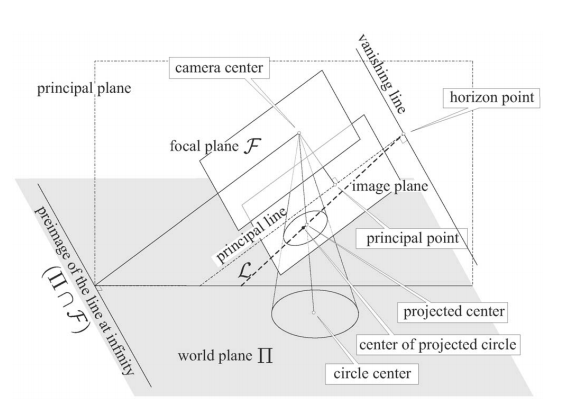

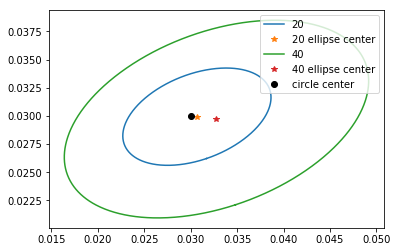

In [10]:
# 半径范围
radius = range(20, 60, 20)
plt.figure('Concentric circles')
r_theta=pi/6
for r in radius:
    f, Pc, radius, r_axis, r_theta, RR, [ff_xc, ff_yc], [Ay, By, Ax, Bx], e_center, e_axes, e_angle = \
    xyz_getRelationData(radius=r, r_theta=r_theta)
    x, y = xyz_getEllipse(e_center[0], e_center[1], e_axes[0]/2, e_axes[1]/2, e_angle)
    plt.plot(x, y, label=str(r))
    plt.plot(e_center[0], e_center[1], '*', label=str(r)+' ellipse center')
plt.plot(ff_xc, ff_yc, 'ko', label='circle center')
plt.legend(loc=1)
plt.show()

## 给定Pc，随机生成r_axis, r_theta，变化radius

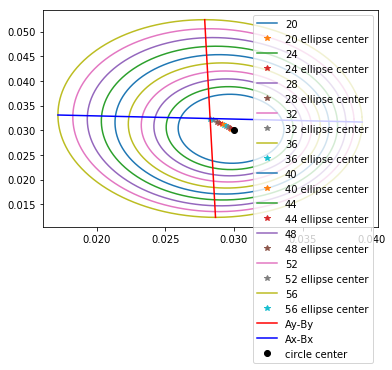

In [13]:
# 旋转轴每一维取值范围[0, 1)
# plt.switch_backend('nbAgg')
u = np.random.random()
v = np.random.random()
w = np.random.random()
r_axis = [u, v, w]
# 旋转角度,弧度， 取值范围[0, pi)
r_theta = np.random.random()*pi
# 半径范围
radius = range(20, 60, 4)
plt.figure('Concentric circles')
#r_theta=pi/6
for r in radius:
    f, Pc, radius, r_axis, r_theta, RR, [ff_xc, ff_yc], [Ay, By, Ax, Bx], e_center, e_axes, e_angle = \
    xyz_getRelationData(radius=r, r_axis=r_axis, r_theta=r_theta)
    x, y = xyz_getEllipse(e_center[0], e_center[1], e_axes[0]/2, e_axes[1]/2, e_angle)
    plt.plot(x, y, label=str(r))
    plt.plot(e_center[0], e_center[1], '*', label=str(r)+' ellipse center')
# 同心圆成像，确定的椭圆中心线，和极轴的关系？
plt.plot([Ay[0], By[0]], [Ay[1], By[1]], 'r', label='Ay-By')
plt.plot([Ax[0], Bx[0]], [Ax[1], Bx[1]], 'b', label='Ax-Bx')
plt.plot(ff_xc, ff_yc, 'ko', label='circle center')
plt.legend(loc=1)
plt.show()

## 倾斜角和线之间的关系

- 空间中仅仅由圆的大小不同，产生的椭圆投影，椭圆中心不同，倾斜角度不同，<span class="mark">是否能够直接确定圆的投影中心？</span>  
    椭圆的五个自由度（xe, ye, a, b, theta）->确定圆心在焦平面上的投影（ff_xc, ff_yc）
    - 我觉得不行，理由
        - 还需要说明这是一个圆的投影，至少显示这是一个圆
        - 这是一个多大的圆（radius）
        - 圆的位姿（位置，倾斜角度，三维坐标，倾斜轴）
        
- 如果能确定圆心在焦平面上的投影(ff_xc, ff_yc)，是否能够使用论文中给定的方法，估计两个倾斜角？（可以，见第2.2.6）  
    空间中的圆（任意位姿）在yoz、xoz平面上的投影是什么样的？（椭圆）
    - 是否能在yoz平面上找到线ACB，AC=BC=radius?（不能）
    - 是否能在xoz平面上找到线ACB，AC=BC=radius?（不能）

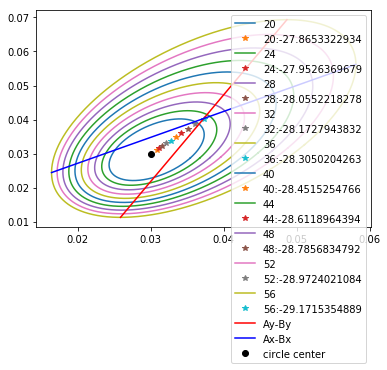

In [14]:
# 旋转轴每一维取值范围[0, 1)
u = np.random.random()
v = np.random.random()
w = np.random.random()
r_axis = [u, v, w]
# 旋转角度,弧度， 取值范围[0, pi)
r_theta = np.random.random()*pi
# 半径范围
radius = range(20, 60, 4)
plt.figure('Concentric circles')
#r_theta=pi/6
for r in radius:
    f, Pc, radius, r_axis, r_theta, RR, [ff_xc, ff_yc], [Ay, By, Ax, Bx], e_center, e_axes, e_angle = \
    xyz_getRelationData(radius=r, r_axis=r_axis, r_theta=r_theta)
    x, y = xyz_getEllipse(e_center[0], e_center[1], e_axes[0]/2, e_axes[1]/2, e_angle)
    plt.plot(x, y, label=str(r))
    plt.plot(e_center[0], e_center[1], '*', label=str(r)+':'+str(e_angle*180/pi))
# 同心圆成像，确定的椭圆中心线，和极轴的关系？
plt.plot([Ay[0], By[0]], [Ay[1], By[1]], 'r', label='Ay-By')
plt.plot([Ax[0], Bx[0]], [Ax[1], Bx[1]], 'b', label='Ax-Bx')
plt.plot(ff_xc, ff_yc, 'ko', label='circle center')
plt.legend(loc=1)
plt.show()

# 如果准确知道(ff_xc, ff_yc)

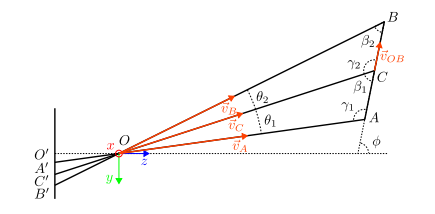

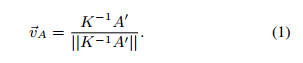

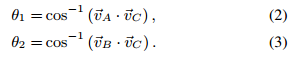

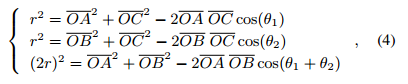

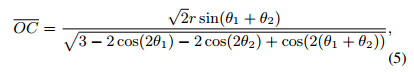

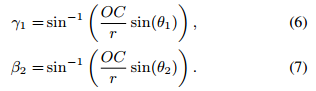

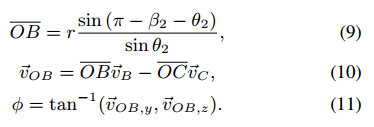

## 计算过程

如果现在准确知道了空间中圆心点投影点${C^{'}}$所在焦平面的坐标${C^{'}}$(ff_xc, ff_yc)，则能通过拟合的椭圆得到圆的位姿，具体过程如下：  
1. 获得焦平面上过点${C^{'}}$，平行y轴的线段${A_y^{'}B_y^{'}}$，其中${A_y^{'}}$${B_y^{'}}$在椭圆上
    - 上图显示的是空间平面OC${B_y^{'}}$，是由圆中心坐标C和原点O以及C在xoz平面上的投影点C_xoz确定的平面
    - 角度${\phi}$也是在面OC${B_y^{'}}$上，向量C${B_y^{'}}$和向量OC_xoz的夹角
- 通过论文过程估计向量C${B_y^{'}}$
- 获得焦平面上过点${C^{'}}$，平行x轴的线段${A_x^{'}B_x^{'}}$，其中${A_x^{'}}$${B_x^{'}}$在椭圆上
    - 上图显示的是空间平面OC${B_x^{'}}$，是由圆中心坐标C和原点O以及C在yoz平面上的投影点C_yoz确定的平面
    - 角度${\phi}$也是在面OC${B_x^{'}}$上，向量C${B_x^{'}}$和向量OC_yoz的夹角
- 通过论文过程估计向量C${B_x^{'}}$
- 确定圆的位置${C}$
    - <span class="mark">能够估计向量OC_y, OC_x（二者很有可能不同），方向相同，但是长度可能计算不同（怎么解决）？</span>
- 如果知道两个向量${CB_y^{'}}$和向量${CB_x^{'}}$，以及圆的位置${C}$，则能在空间中唯一确定圆
    - 相当于知道空间中圆上的三点，则能唯一确定一个圆（实际上是确定圆所在平面，由于半径已知，故能唯一确定空间中的圆）

### 模拟计算说明

假设已知圆在焦平面上的投影点${C^{'}}$，和焦平面上的椭圆(e_center, e_axes, e_angle)，圆半径radius，焦距f，按照论文上的方式计算圆的位姿。  
- 圆只需要绕着Z轴旋转即可，可以简化旋转函数，只有两个自由度，平面的法向量旋转到和Z平行即可
- <span class="mark">是否两次计算圆的中心长度一致？很有可能不一样（因为圆中心投影点是不精确的）</span>
    - 使用同心圆确定的${C^{'}}$作为初始值，选择周围的一个区域，计算${d(C^{'}, \gamma, Q^{'})}$
    - 如果每一次计算的d都相同，则${C^{'}}$是一个候选值，实际可以使用最小方差来决定${C^{'}}$
    - <span class="mark">如果是准确值，会发现在周围区域有两个最优值，这是由于对称性造成的（是否说这两个空间圆，成像后的椭圆相同？）××××××</span>
- 如何确定这两个最优值
    - P260

按照之前的方式进行计算，先看计算的圆和给定的圆是否一致？  
如果一致，尝试找另外一个对称的圆，在焦平面上的投影也是相同的椭圆？怎么找？
- 找到过圆心的直径（A，C，B)，分别是x,y两个方向的
- 找到对称轴, ∠AOB的角平分线
- 找到点C关于该角平分线对称的点C‘，AB的对应点A‘，B’
- 以点C’作为圆心，计算圆的位姿，在空间成像
- 然后将圆C‘在焦平面上投影，观察是否一致

### 求解lineAndEllipse焦点（testAndPlot）

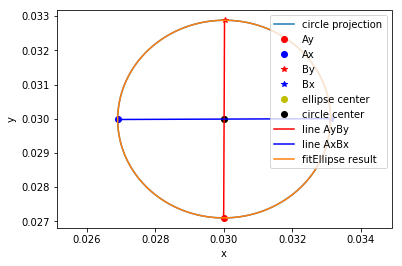

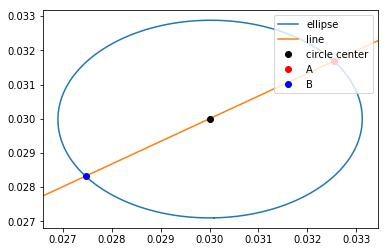

In [15]:
f=0.08
f, Pc, radius, r_axis, r_theta, RR, [ff_xc, ff_yc], [Ay, By, Ax, Bx], e_center, e_axes, e_angle=\
xyz_getRelationData(Pc=[10, 10, 10], radius=1, r_theta=3*pi/180, draw_result=True, scal=20000)
gamma = np.random.random()*pi
Ap, Bp = xyz_calcIntersectionOfLineAndEllipse(ff_xc, ff_yc, gamma, e_center[0], e_center[1], e_axes[0]/2, e_axes[1]/2, e_angle)
x_e, y_e = xyz_getEllipse(e_center[0], e_center[1], e_axes[0]/2, e_axes[1]/2, e_angle)
x_l, y_l = xyz_getLine(ff_xc, ff_yc, gamma, length=0.05)
[xmin, xmax, ymin, ymax] = plt.axis()
plt.figure()
plt.plot(x_e, y_e, label='ellipse')
plt.plot(x_l, y_l, label='line')
plt.plot(ff_xc, ff_yc, 'ko', label='circle center')
plt.plot(Ap[0], Ap[1], 'ro', label='A')
plt.plot(Bp[0], Bp[1], 'bo', label='B')
#plt.axis([Ax[0], Bx[0], Ay[1], By[1]])
plt.axis([xmin, xmax, ymin, ymax])
plt.legend(loc=1)
plt.show()

### 求解投影线对应空间圆上的一点(testAndPlot)

1. 误差来源：
    1. 成像误差
    - 椭圆估计误差
        1. 导致圆中心投影估计误差
        - 过圆中心的线反变换回去不是在直径上
    - 计算精度问题，在估计椭圆的时候，不使用cv.fitellipse?
2. 误差规律：
    1. 圆离得越远，误差越大 
3. 假设：
    1. 圆总体上是朝着相机的，倾斜的角度不大  

**旋转轴是[1, -1, 0]，旋转角度变化，和估计的phi的整体趋势**  
当旋转角大致为36°时，成像几乎是一条直线，此时估计误差大  
${sin\phi = \frac{\sqrt3}{3}}$

0.0 10.0 10.0 10.0
9.0 9.99999999999 9.99999999999 9.99999999999
18.0 10.0 10.0 10.0
27.0 10.0000000005 10.0000000005 10.0000000005
36.0 9.99999984033 9.99999984033 9.99999984033
45.0 9.99999999991 9.99999999991 9.99999999991
54.0 9.99999999991 9.99999999991 9.99999999991
63.0 10.0000000001 10.0000000001 10.0000000001
72.0 9.99999999999 9.99999999999 9.99999999999
81.0 10.0 10.0 10.0


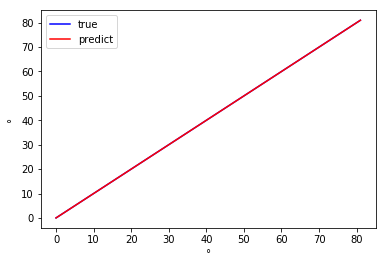

In [36]:
theta_List = np.arange(0, 90, 90/10)
f=0.08
phi_List = []
for r_theta in theta_List:
    f, Pc, radius, r_axis, r_theta, RR, [ff_xc, ff_yc], [Ay, By, Ax, Bx], [xe, ye], [a_2, b_2], phi=\
    xyz_getRelationData(f=f, Pc = [10, 10, 10], radius=1, r_axis=[1, -1, 0], r_theta=r_theta*pi/180, scal=100000)
    a = a_2/2
    b = b_2/2
    # 求解空间圆上的一点
    [xc, yc, zc], [xa, ya, za], voa, vob, voc, phi = \
    xyz_calcCircleCenterAndAPoint(ff_xc, ff_yc, xe, ye, a, b, phi, gamma=pi/4, f=f, radius=radius)
    print(r_theta*180/pi, xc, yc, zc)
    phi_List.append(90 - phi*180/pi)
plt.figure()
plt.plot(theta_List, theta_List, 'b', label='true')
plt.plot(theta_List, phi_List, 'r', label='predict')
plt.xlabel('°')
plt.ylabel('°')
plt.legend()
plt.show()

- 三个向量：
[ 0.56308707  0.56308707  0.6048685 ]
[ 0.58973249  0.58973249  0.55175284]
[ 0.57735027  0.57735027  0.57735027]
- 两个theta角度：
1.9549899293622723 1.7770415811763267
- 圆半径，oc投影长度
1 17.320508075694836
- gama1, beta2分别可能的2个解：
36.21937961212686 143.78062038787314 32.48734810158865 147.51265189841135
- gama1, beta2解：
2 143.78062038787314 32.48734810158865
- ob投影长度：
18.155688131957852
- cb向量：
[ 0.70699909  0.70699909  0.01745241]
- 倾斜角度phi：
89.00000000001148
圆心坐标： 10.0 10.0 10.0
A坐标： 10.7069990854 10.7069990854 10.0174524064


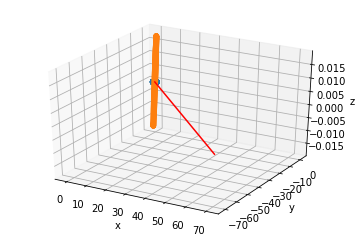

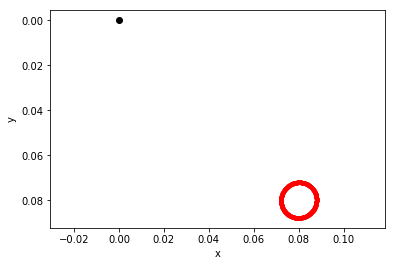

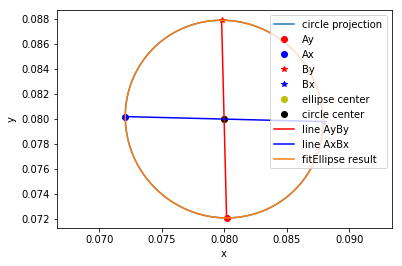

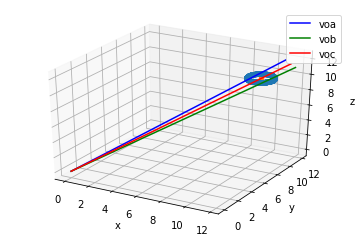

In [37]:
# -已知f, radius, Pc, r_axis, r_theta, 生成空间中的圆，并进行成像
f=0.08
Pc=[10, 10, 10]
radius=1
f, Pc, radius, r_axis, r_theta, RR, [ff_xc, ff_yc], [Ay, By, Ax, Bx], [xe, ye], [a_2, b_2], phi=\
xyz_getRelationData(f=f, Pc=Pc, radius=radius, r_axis=[1, -1, 0], r_theta=1*pi/180, draw_result=True, draw_flag=True, scal=10000)
a = a_2/2
b = b_2/2
# 求解空间圆上的一点
[xc, yc, zc], [xa, ya, za], voa, vob, voc, phi = \
xyz_calcCircleCenterAndAPoint(ff_xc, ff_yc, xe, ye, a, b, phi, gamma=pi/4, f=f, radius=radius, show_message=True)
print('圆心坐标：', xc, yc, zc)
print('A坐标：', xa, ya, za)
# plot result
fig = plt.figure('xyz')
ax = fig.add_subplot(1,1,1, projection='3d')
x, y = xyz_getCircle(0, 0, radius)
points = np.zeros((len(x), 3))
points[:, 0] = x
points[:, 1] = y
points[:, 2] = 0
r_theta, r_axis, points_extent_draw, RR = xyz_rotation(points, r_theta=r_theta, r_axis=r_axis)
points_extent_draw[:, 0] += Pc[0]
points_extent_draw[:, 1] += Pc[1]
points_extent_draw[:, 2] += Pc[2]
ax.scatter(points_extent_draw[:,0], points_extent_draw[:,1], points_extent_draw[:,2])
scal = 20
ax.plot3D([voa[0]*scal, 0], [voa[1]*scal, 0], [voa[2]*scal, 0], 'b', label='voa')
ax.plot3D([vob[0]*scal, 0], [vob[1]*scal, 0], [vob[2]*scal, 0], 'g', label='vob')
ax.plot3D([voc[0]*scal, 0], [voc[1]*scal, 0], [voc[2]*scal, 0], 'r', label='voc')
ax.scatter(Pc[0], Pc[1], Pc[2], 'o')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.legend()
plt.show()

In [18]:
print(points_extent_draw[1:10, :])
print(xe, ye)
print(np.dot(RR, np.array([1,1,0,1])))

[[ 10.99990359  10.0062128   10.01241809   1.        ]
 [ 10.99984378  10.01250151  10.01249497   1.        ]
 [ 10.99974442  10.01878973  10.01257135   1.        ]
 [ 10.99960551  10.0250772   10.01264724   1.        ]
 [ 10.99942706  10.03136368  10.01272263   1.        ]
 [ 10.99920908  10.03764892  10.01279752   1.        ]
 [ 10.99895157  10.04393267  10.0128719    1.        ]
 [ 10.99865454  10.05021468  10.01294577   1.        ]
 [ 10.99831801  10.05649471  10.01301913   1.        ]]
0.0799903725716 0.0799903725716
[ 0.9998477   0.9998477   0.02468143  1.        ]


## 空间中圆在yoz平面上的投影

论文中投影平面有误，不是在yoz平面上，而是在圆中心坐标C和原点O以及C在xoy平面上的投影点C_xoy确定的平面

<span class="mark">实际上并非是投影面，是在空间中平面，由光心O和过C’的直线确定的平面</span>

可以从图中观察，椭圆长轴长不总是2倍的半径；空间圆在yoz平面上投影，不能找到长度为2倍半径的线段。

In [ ]:
# 产生一个空间中圆
# f, Pc, radius, r_axis, r_theta, RR, [ff_xc, ff_yc], [Ay, By, Ax, Bx], e_center, e_axes, e_angle \
# = xyz_getRelationData(f=0.03, Pc=[60, 60, 60], radius=60, r_axis=[1, 1, 0], r_theta=0.0, draw_flag=False, draw_result=False)
radius = 60
xc, yc, zc = 100, 100, 100
# 旋转轴每一维取值范围[0, 1)
u = np.random.random()
v = np.random.random()
w = np.random.random()
r_axis = [u, v, w]
# 旋转角度,弧度， 取值范围[0, pi)
r_theta = np.random.random()*pi

x, y = xyz_getCircle(0, 0, radius, num=10000)
points = np.zeros((len(x), 3))
points[:, 0] = x
points[:, 1] = y
points[:, 2] = 0
# 旋转一个角度
r_theta, r_axis, r_points, RR = xyz_rotation(points, r_theta=r_theta, r_axis=r_axis)
r_points[:, 0] += xc
r_points[:, 1] += yc
r_points[:, 2] += zc
# 在yoz平面上进行投影
# 在yoz平面投影是否是一个椭圆？
yoz_center, yoz_axes, yoz_angle = xyz_fitEllipse(r_points[:, 1], r_points[:, 2], scal=200)
x_e, y_e = xyz_getEllipse(yoz_center[0], yoz_center[1], yoz_axes[0]/2, yoz_axes[1]/2, yoz_angle)
# plot显示结果
plt.figure()
plt.plot(r_points[:, 1], r_points[:, 2], label='yoz')
plt.plot(yc, zc, 'ko', label='circle center')
plt.plot(x_e, y_e, label='ellipse')
plt.plot(yoz_center[0], yoz_center[1], 'r*', label='ellipse center')
print('a: {}, b: {}'.format(yoz_axes[0], yoz_axes[1]))
plt.legend(loc=1)
plt.show()

# 模拟圆位置相同，位姿不同成像

## 绕轴[1, -1, 0]旋转，圆位置[10, 10, 10]，radius=1

r_theta is 0.0, ellipse center is -1.1978854817838857e-20,6.203797364666154e-22
r_theta is 0.3, ellipse center is -2.9618686358926e-07,-2.961868635892625e-07
r_theta is 0.6, ellipse center is -5.923417341107653e-07,-5.923417341107643e-07
r_theta is 0.9, ellipse center is -8.884326217937662e-07,-8.884326217937972e-07
r_theta is 1.2, ellipse center is -1.184427543462418e-06,-1.1844275434624424e-06
r_theta is 1.5, ellipse center is -1.4802945258317103e-06,-1.4802945258318297e-06
r_theta is 1.8, ellipse center is -1.7760016088036229e-06,-1.7760016088035915e-06
r_theta is 2.1, ellipse center is -2.0715168487614107e-06,-2.0715168487614133e-06
r_theta is 2.4, ellipse center is -2.3668083218634005e-06,-2.3668083218633366e-06
r_theta is 2.7, ellipse center is -2.661844127334304e-06,-2.6618441273343143e-06
circle center project position is [ 0.],[ 0.]


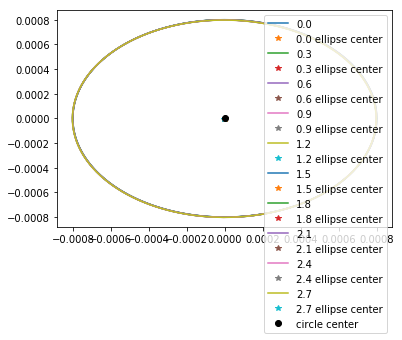

In [19]:
# 倾斜角范围
f = 0.008#8 mm
r_thetaList = np.arange(0, 3, 3/10)
plt.figure('r_theta change [0, 3]')
radius = 1
Pc = np.array([0, 0, 10])
r_axis = [1, -1, 0]
for r_theta in r_thetaList:
    f, Pc, radius, r_axis, r_theta, RR, [ff_xc, ff_yc], [Ay, By, Ax, Bx], e_center, e_axes, e_angle = \
    xyz_getRelationData(f=f, Pc=Pc, r_axis=r_axis, radius=radius, r_theta=r_theta*pi/180, scal=10000)
    x, y = xyz_getEllipse(e_center[0], e_center[1], e_axes[0]/2, e_axes[1]/2, e_angle)
    plt.plot(x, y, label=str(r_theta*180/pi))
    plt.plot(e_center[0], e_center[1], '*', label=str(r_theta*180/pi)+' ellipse center')
    print('r_theta is {:.1f}, ellipse center is {},{}'.format(r_theta*180/pi, e_center[0], e_center[1]))
print('circle center project position is {},{}'.format(ff_xc, ff_yc))
plt.plot(ff_xc, ff_yc, 'ko', label='circle center')
plt.legend(loc=1)
plt.show()

## 圆法线方向变化，射影变化

RA is 0.000, ellipse center is -0.00000000,-0.00000000
RA is 0.600, ellipse center is -0.00000035,-0.00000076
RA is 1.200, ellipse center is -0.00000130,0.00000106
RA is 1.800, ellipse center is -0.00000242,-0.00000068
RA is 2.400, ellipse center is -0.00000332,-0.00000045
circle center project position is [ 0.],[ 0.]


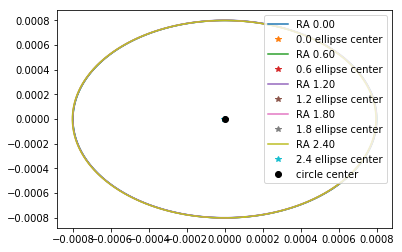

In [20]:
# 倾斜角范围
f = 0.008#8 mm
radius = 1
Pc = np.array([0, 0, 10])
# 随机次数
randomTime = 5
# 法线和Z轴夹角范围，角度
angleNormalRange = 3
# 随机生成法线方向
Normal_Z = 100
R_range = tan(angleNormalRange*pi/180)*Normal_Z
angleList = np.arange(0, angleNormalRange, angleNormalRange/randomTime)
#r_List = np.random.random(size=randomTime)*R_range
r_List = np.tan(angleList*pi/180)*Normal_Z
r_Theta = np.random.random(size=randomTime)*2*pi
plt.figure('angleNormalRange change [0, 3]')

for i in range(randomTime):
    Normal = [r_List[i]*cos(r_Theta[i]), r_List[i]*sin(r_Theta[i]), Normal_Z]
    rotation_angle = np.arccos(Normal[2]/np.linalg.norm(Normal, 2))*180/pi
    f, Pc, radius, Normal, [ff_xc, ff_yc], [Ay, By, Ax, Bx], e_center, e_axes, e_angle=\
    xyz_getRelationDataFromNormal(f=f, Pc=Pc, radius=radius, Normal=Normal)
    #rotation_angle = np.arccos(Normal[2])*180/pi
    #f, Pc, radius, r_axis, r_theta, RR, [ff_xc, ff_yc], [Ay, By, Ax, Bx], e_center, e_axes, e_angle = \
    #xyz_getRelationData(f=f, Pc=Pc, r_axis=r_axis, radius=radius, r_theta=r_theta*pi/180, scal=10000)
    x, y = xyz_getEllipse(e_center[0], e_center[1], e_axes[0]/2, e_axes[1]/2, e_angle)
    plt.plot(x, y, label='RA {:.2f}'.format(rotation_angle))
    plt.plot(e_center[0], e_center[1], '*', label=str(rotation_angle)+' ellipse center')
    print('RA is {:.3f}, ellipse center is {:.8f},{:.8f}'.format(rotation_angle, e_center[0], e_center[1]))
print('circle center project position is {},{}'.format(ff_xc, ff_yc))
plt.plot(ff_xc, ff_yc, 'ko', label='circle center')
plt.legend(loc=1)
plt.show()

## 圆法线方向变化，反向求解圆位置位姿

In [66]:
# 倾斜角范围
f = 0.008#8 mm
radius = 1
Pc = np.array([1, 1, 10])
# 随机次数
randomTime = 5
# 法线和Z轴夹角范围，角度
angleNormalRange = 3
# 随机生成法线方向
Normal_Z = 100
R_range = tan(angleNormalRange*pi/180)*Normal_Z
angleList = np.arange(0, angleNormalRange, angleNormalRange/randomTime)
#r_List = np.random.random(size=randomTime)*R_range
r_List = np.tan(angleList*pi/180)*Normal_Z
r_Theta = np.random.random(size=randomTime)*2*pi
# plt.figure('angleNormalRange change [0, 3]')

for i in range(randomTime):
    Normal = [r_List[i]*cos(r_Theta[i]), r_List[i]*sin(r_Theta[i]), Normal_Z]
    rotation_angle = np.arccos(Normal[2]/np.linalg.norm(Normal, 2))*180/pi
    f, Pc, radius, Normal, [ff_xc, ff_yc], [Ay, By, Ax, Bx], e_center, e_axes, e_angle=\
    xyz_getRelationDataFromNormal(f=f, Pc=Pc, radius=radius, Normal=Normal, draw_flag=0, draw_result=0)
    [xe, ye] = e_center
    a = e_axes[0]/2
    b = e_axes[1]/2
    phi = e_angle
    #rotation_angle = np.arccos(Normal[2])*180/pi
    #f, Pc, radius, r_axis, r_theta, RR, [ff_xc, ff_yc], [Ay, By, Ax, Bx], e_center, e_axes, e_angle = \
    #xyz_getRelationData(f=f, Pc=Pc, r_axis=r_axis, radius=radius, r_theta=r_theta*pi/180, scal=10000)
    # 求解空间圆上的一点
    # 使用真实的圆投影点进行计算
    print('-----------------------')
    [xc1, yc1, zc1], [x1, y1, z1], voa, vob, voc, phi = \
    xyz_calcCircleCenterAndAPoint(ff_xc, ff_yc, xe, ye, a, b, phi, gamma=0, f=f, radius=radius,show_message=0)
    [xc2, yc2, zc2], [x2, y2, z2], voa, vob, voc, phi = \
    xyz_calcCircleCenterAndAPoint(ff_xc, ff_yc, xe, ye, a, b, phi, gamma=pi/2, f=f, radius=radius,show_message=0)
    print('倾斜角度 {:.2f}'.format(rotation_angle))
    print("两次计算圆在三维空间中位置: ", [xc1, yc1, zc1], [xc2, yc2, zc2])
    print("两次计算圆在三维空间中两点: ", [x1, y1, z1], [x2, y2, z2])
    # 计算圆位姿
    [x1, y1, z1] = [x1-xc1, y1-yc1, z1-zc1]
    [x2, y2, z2] = [x2-xc2, y2-yc2, z2-zc2]
    n_cal = np.array([y1*z2-y2*z1, -x1*z2+x2*z1, x1*y2-x2*y1])
    n_cal = n_cal/np.linalg.norm(n_cal, 2)
    #print(np.dot(np.array([x1,y1,z1]), n_cal))
    #print(np.dot(np.array([x2,y2,z2]), n_cal))
    print('error_circle: {}'.format(np.arccos(np.dot(Normal, n_cal))*180/pi))
    print('圆位姿： ', Normal, n_cal)
    
    # 默认椭圆中心为圆投影点进行计算
    [xc1, yc1, zc1], [x1, y1, z1], voa, vob, voc, phi = \
    xyz_calcCircleCenterAndAPoint(xe, ye, xe, ye, a, b, phi, gamma=0, f=f, radius=radius,show_message=0)
    [xc2, yc2, zc2], [x2, y2, z2], voa, vob, voc, phi = \
    xyz_calcCircleCenterAndAPoint(xe, ye, xe, ye, a, b, phi, gamma=pi/2, f=f, radius=radius,show_message=0)
    print('倾斜角度 {:.2f}'.format(rotation_angle))
    print("两次计算圆在三维空间中位置: ", [xc1, yc1, zc1], [xc2, yc2, zc2])
    print("两次计算圆在三维空间中两点: ", [x1, y1, z1], [x2, y2, z2])
    # 计算圆位姿
    [x1, y1, z1] = [x1-xc1, y1-yc1, z1-zc1]
    [x2, y2, z2] = [x2-xc2, y2-yc2, z2-zc2]
    n_cal = np.array([y1*z2-y2*z1, -x1*z2+x2*z1, x1*y2-x2*y1])
    n_cal = n_cal/np.linalg.norm(n_cal, 2)
    #print(np.dot(np.array([x1,y1,z1]), n_cal))
    #print(np.dot(np.array([x2,y2,z2]), n_cal))
    print('error_ellipse: {}'.format(np.arccos(np.dot(Normal, n_cal))*180/pi))
    print('圆位姿： ', Normal, n_cal)
    print('-----------------------')
plt.show()
#没有评价标准
#倾斜角越大计算误差越大
#如果认为椭圆中心就是圆投影中心，位置有偏差，位姿偏差较大

-----------------------
倾斜角度 0.00
两次计算圆在三维空间中位置:  [0.99999999999999734, 0.99999999999999734, 9.9999999999999734] [1.0000000000000031, 1.0000000000000031, 10.00000000000003]
两次计算圆在三维空间中两点:  [2.0000000000000009, 0.99999999999999856, 9.999999999999984] [0.99999999999999578, 1.999999999999992, 9.9999999999999574]
error_circle: 0.0
圆位姿：  [ 0. -0.  1.] [ -1.06581410e-14   7.28306304e-14   1.00000000e+00]
倾斜角度 0.00
两次计算圆在三维空间中位置:  [1.0000000000000031, 1.0000000000000033, 10.00000000000003] [1.0000000000000031, 1.0000000000000033, 10.00000000000003]
两次计算圆在三维空间中两点:  [1.9999999999999918, 0.99999999999999578, 9.9999999999999574] [0.99999999999999578, 1.9999999999999909, 9.9999999999999574]
error_ellipse: 0.0
圆位姿：  [ 0. -0.  1.] [  7.28306304e-14   7.28306304e-14   1.00000000e+00]
-----------------------
-----------------------
倾斜角度 0.60
两次计算圆在三维空间中位置:  [0.99999999999997613, 0.99999999999997613, 9.999999999999762] [1.0014557914917961, 1.0014557914917961, 10.01455791491796]
两次计算圆在三维空间中两点:  [1.99998

# 同心圆成像，确定ff_xc, ff_yc

没有看明白同心圆成像，确定圆心投影

## 获得过圆投影中心的四点

In [79]:
# 使用数学库计算ff_xc, ff_yc
f=0.008; Pc=[1, 1, 10]; radius1=1; radius2=2
# Normal=np.random.randn(3)
Normal = [0.1, 0.1, 1]
f, Pc, radius, Normal, [ff_xc, ff_yc], [Ay, By, Ax, Bx], e_center1, e_axes1, e_angle1 = \
xyz_getRelationDataFromNormal(f=f, Pc=Pc, radius=radius1, Normal=Normal)
f, Pc, radius, Normal, [ff_xc, ff_yc], [Ay, By, Ax, Bx], e_center2, e_axes2, e_angle2 = \
xyz_getRelationDataFromNormal(f=f, Pc=Pc, radius=radius2, Normal=Normal)
# 计算椭圆中心斜线斜率p1p2
xe1, ye1 = e_center1
xe2, ye2 = e_center2
gamma = np.arctan((ye2-ye1)/(xe2-xe1))
[ax1, ay1], [bx1, by1] = xyz_calcIntersectionOfLineAndEllipse(xe1, ye1, gamma, xe1, ye1, e_axes1[0]/2, e_axes1[1]/2, e_angle1)
[ax2, ay2], [bx2, by2] = xyz_calcIntersectionOfLineAndEllipse(xe1, ye1, gamma, xe2, ye2, e_axes2[0]/2, e_axes2[1]/2, e_angle2)
# plot
plt.figure()
x, y = xyz_getEllipse(xe1, ye1, e_axes1[0]/2, e_axes1[1]/2, e_angle1)
plt.plot(x, y, label='ellipse1')
x, y = xyz_getEllipse(xe2, ye2, e_axes2[0]/2, e_axes2[1]/2, e_angle2)
plt.plot(x, y, label='ellipse2')
plt.plot(ax1, ay1, '.', label='a1')
plt.plot(bx1, by1, '.', label='b1')
plt.plot(ax2, ay2, '.', label='a2')
plt.plot(bx2, by2, '.', label='b2')
plt.plot(ff_xc, ff_yc, 'ko', label='circle center')
plt.plot(xe1, ye1, '.', label='ellipse1 center')
plt.plot(xe2, ye2, '.', label='ellipse2 center')
plt.legend(loc=1)
plt.show()

## 使用交比的方式求解

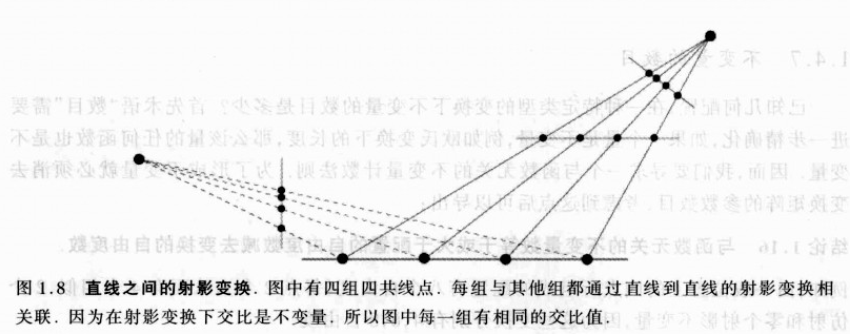

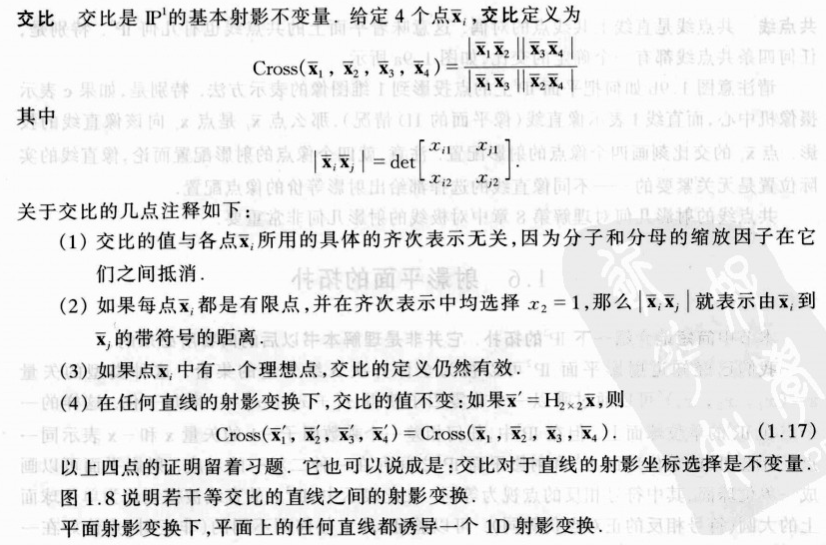

In [80]:
# 已知四个交点(a1,b1,a2,b2), r, R(a点总在b的上方或者右方)
# 求解圆中心投影ff_xc, ff_yc
def xyz_calc_ffxcffycFromcrossRatio(x1, x2, x3, xx1, xx2, xx3, xx0=0):
    '''
    [u0, v0] = xyz_calc_ffxcffycFromcrossRatio()
    知道空间共线4点，和其中射影变换共线3点，计算射影变换另外一点坐标
    ----------------
    input:
    x1, x2, x3:[u, v]:射影变换三点
    xx0, xx1, xx2, xx3：空间共线4点，默认xx0对应直线的0点
    ----------------
    output:
    xx0对应的射影变化横纵坐标
    [u0, v0]
    ----------------
    '''
    u1, v1 = x1
    u2, v2 = x2
    u3, v3 = x3
    crossRatio = ((xx0-xx1)*(xx2-xx3))/((xx0-xx2)*(xx1-xx3))
    # crossRatio = ((u0-u1)*(u2-u3))/((u0-u2)*(u1-u3))
    tmp_u = crossRatio*(u1-u3)/(u2-u3)
    tmp_v = crossRatio*(v1-v3)/(v2-v3)
    u0 = (u1 - tmp_u*u2)/(1 - tmp_u)
    v0 = (v1 - tmp_v*v2)/(1 - tmp_v)
    return [u0, v0]
r, R = radius1, radius2
x1, xx1 = [bx2, by2], -R
x2, xx2 = [bx1, by1], -r
x3, xx3 = [ax1, ay1], r
x4, xx4 = [ax2, ay2], R
# 从(x1, x2, x3, x4)中取三点能计算一个解 
# (x1,x2,x3)
[u0, v0] = xyz_calc_ffxcffycFromcrossRatio(x1, x2, x3, xx1, xx2, xx3)
print(u0, v0)
# (x1,x2,x4)
[u0, v0] = xyz_calc_ffxcffycFromcrossRatio(x1, x2, x4, xx1, xx2, xx4)
print(u0, v0)
# (x1,x3,x4)
[u0, v0] = xyz_calc_ffxcffycFromcrossRatio(x1, x3, x4, xx1, xx3, xx4)
print(u0, v0)
# (x2,x3,x4) 
[u0, v0] = xyz_calc_ffxcffycFromcrossRatio(x2, x3, x4, xx2, xx3, xx4)
print(u0, v0)

0.0007999999999999943 0.0008000000000000088
0.0007999999999999937 0.0008000000000000085
0.0007999999999999954 0.0008000000000000097
0.0007999999999999948 0.0008000000000000096


In [81]:
print(ff_xc, ff_yc)

[ 0.0008] [ 0.0008]


## 求解方程组形式计算圆投影中心

使用空间约束求解，未出来正确结果，错误未知

In [ ]:
# 获得Intrinsic matrix（内参矩阵）
K = np.array([[f, 0, 0],
             [0, f, 0],
             [0, 0, 1]])

# 求四个向量在空间中的直线方向向量
va1 = np.dot(np.linalg.inv(K), np.array([ax1, ay1, 1]))
va1 = voa/np.linalg.norm(va1, 2)
vb1 = np.dot(np.linalg.inv(K), np.array([bx1, by1, 1]))
vb1 = vob/np.linalg.norm(vb1, 2)

va2 = np.dot(np.linalg.inv(K), np.array([ax2, ay2, 1]))
va2 = voa/np.linalg.norm(va2, 2)
vb2 = np.dot(np.linalg.inv(K), np.array([bx2, by2, 1]))
vb2 = vob/np.linalg.norm(vb2, 2)
print(va1, vb1, va2, vb2)

In [ ]:
# 使用方程约束，求解
a,b,c,d = sympy.symbols('a,b,c,d')
[x1, y1, z1] = b*vb1 - a*va1
[x2, y2, z2] = d*vb2 - c*va2
[x11, y11, z11] = b*vb1 + a*va1
[x22, y22, z22] = d*vb2 + c*va2

#va1, vb1, va2, vb2
# result = sympy.solve([np.linalg.norm(a*va1-b*vb1, 2) - 2*radius1, \
#                       np.linalg.norm(c*va2-d*vb2, 2) - 2*radius2, \
#                       y1*z2 - y2*z1, \
#                       x1*z2 - x2*z1, \
#                       x1*y2 - x2*y1],\
#                      [a,b,c,d])
result = sympy.solve([x1**2+y1**2+z1**2 - 4*radius1**2, \
                      x2**2+y2**2+z2**2 - 4*radius2**2, \
                      y1*z2 - y2*z1, \
                      x1*z2 - x2*z1, \
                      x1*y2 - x2*y1],\
                     [a,b,c,d])
result = sympy.solve([x1**2+y1**2+z1**2 - 4*radius1**2, \
                      x2**2+y2**2+z2**2 - 4*radius2**2, \
                      y1*z2 - y2*z1, \
                      x1*z2 - x2*z1, \
                      x1*y2 - x2*y1, \
                      x11 - x22, \
                      y11 - y22, \
                      z11 - z22],\
                     [a,b,c,d])
print(result)
for (a, b, c, d) in result:
    [x1, y1, z1] = b*vb1 - a*va1
    [x2, y2, z2] = d*vb2 - c*va2
    print(x1**2+y1**2+z1**2 - 4*radius1**2, x2**2+y2**2+z2**2 - 4*radius2**2, y1*z2 - y2*z1, x1*z2 - x2*z1, x1*y2 - x2*y1)
    [x11, y11, z11] = (b*vb1 + a*va1)/2
    [x22, y22, z22] = (d*vb2 + c*va2)/2
    print(x11, y11, z11)
    print(x22, y22, z22)
    print(np.dot(K, [x11, y11, z11])/z11)
    print(np.dot(K, [x22, y22, z22])/z22)

# 整个过程仿真

## 同心圆成像过程

In [49]:
# 在jupyter notebook中显示
# plt.switch_backend('nbAgg')
# 在独立窗口显示
# plt.switch_backend('Qt5Agg')
def xyz_simulationImageRing(f=8e-3, du=5.5e-6, dv=5.5e-6, width=2048, height=2048, R=0.654, r=0.597, Pc=[0,0,10], angleNormalRange=3, Normal=None, CircleNum=5000, plot_flag=False):
    '''
    Normal, Pc, img, numPointsOfImg=xyz_simulationImageRing()
    ---------------
    input:
    f=8e-3:相机焦距
    du=5.5e-6:横坐标像元尺寸，width(图像宽度)方向长度为du算一个像元，fx/du，图像中的列
    dv=5.5e-6:纵坐标像元尺寸，height(图像高度)方向长度为dv算一个像元，fy/dv，图像中的行
    width:int:图像宽度（列数）
    height:int:图像高度（行数）
    - [height, width] = img.shape
    R=0.654:外圆半径
    r=0.597:内圆半径
    Pc=[0,0,10]: 环中心的三维位置
    Normal=None: 如果法向量为空，则随机生成法向量，若不为空，按照指定法向量为环位姿
    angleNormalRange=3:环位姿（平面法向量）偏角范围，角度
    CircleNum=5000:内外环仿真点数量
    ---------------
    output:
    Normal：环位姿:[a,b,c]
    Pc：环中心三维位置:[xc,yc,zc]
    img：环成像:np.array()2048*2048*3
    numPointsOfImg：环成像亮点个数
    ---------------
    '''
    # # 显示整个过程
    # plot_flag = False
    # # 1.相机参数
    # f, du, dv = 8e-3, 5.5e-6, 5.5e-6
    # width, height = 2048, 2048
    # # 2.内外半径r=0.597m, R=0.597+0.57=0.654m
    # R, r = 0.654, 0.597
    # # 3.椭圆位置+位姿信息
    #     # 3.1椭圆位置
    # Pc = [0,0,10]
    #     # 3.2法线和Z轴夹角范围，角度
    # angleNormalRange = 60
        # 3.3随机生成法线方向
    if Normal is None:
        Normal_Z = 1
        angleRandom = np.random.random()*angleNormalRange
        r_Random = np.tan(angleRandom*pi/180)*Normal_Z
        r_ThetaRandom = np.random.random()*2*pi
        Normal = [r_Random*cos(r_ThetaRandom), r_Random*sin(r_ThetaRandom), Normal_Z]
    # 4.获得xoy平面上的环
    CircleNum = 2000
    [x1, y1] = xyz_getCircle(0, 0, R, num=CircleNum)
    [x2, y2] = xyz_getCircle(0, 0, r, num=CircleNum)
    points = np.zeros((len(x1)+len(x2), 3))
    points[:len(x1), 0] = x1
    points[:len(x1), 1] = y1
    points[len(x1):(len(x1)+len(x2)), 0] = x2
    points[len(x1):(len(x1)+len(x2)), 1] = y2
    points[:, 2] = 0
    # 5.进行旋转变换到目标法向量平面上，平移到目标（圆环中心）位置
    points_draw, Normal, Rx, Ry = xyz_rotation_circle(points, N=Normal, name='rotation', draw_flag=plot_flag)
    points = points_draw.copy()
    points[:, 0] += Pc[0]
    points[:, 1] += Pc[1]
    points[:, 2] += Pc[2]
    # 6.获得焦平面上的点
    [xx, yy] = xyz_projection(points, name='focal flat', draw_flag=plot_flag, f=f)
    # 7.焦平面上的点到像平面
    img = np.zeros((height, width, 3), dtype=np.uint8)
    u0, v0 = width//2, height//2
    imgx = xx//du + u0
    imgy = yy//dv + v0
    imgxx = []
    imgyy = []
    for i in range(len(imgx)):
        if imgx[i]>=0 and imgx[i]<=width:
            if imgy[i]>=0 and imgy[i]<=height:
                imgxx.append(int(imgx[i]))
                imgyy.append(int(imgy[i]))
    img[imgyy, imgxx, :] = 255
    numPointsOfImg = len(np.nonzero(img)[2])//3
    if plot_flag:
        plt.figure('image has {} points'.format(numPointsOfImg))
        plt.imshow(img)
        plt.grid(b='on')
    return Normal, Pc, img, numPointsOfImg

## 随着距离的变化，图像的变化

<IPython.core.display.Javascript object>


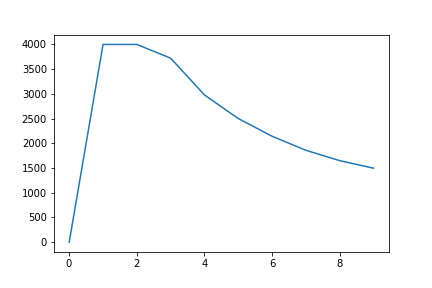

In [50]:
f=8e-3
# 3.3随机生成法线方向
angleNormalRange = 60
Normal_Z = 1
angleRandom = np.random.random()*angleNormalRange
r_Random = np.tan(angleRandom*pi/180)*Normal_Z
r_ThetaRandom = np.random.random()*2*pi
Normal = [r_Random*cos(r_ThetaRandom), r_Random*sin(r_ThetaRandom), Normal_Z]
distanceList = np.arange(f, 10, (10-f)/10)
numPoints = []
for d in distanceList:
    _,_,_,num = xyz_simulationImageRing(Pc=[0,0,d], Normal=None, angleNormalRange=0)
    numPoints.append(num)
plt.switch_backend('nbAgg')
plt.figure()
plt.plot(distanceList, numPoints)
plt.show()
#随着距离的增加，先增后减，说明太近只能看到一部分，太远看到很少

## 具体成像显示

In [52]:
plt.switch_backend('Qt5Agg')
result = xyz_simulationImageRing(Pc=[0,0,10], plot_flag=True, angleNormalRange=0)
plt.show()

## 随着距离的变化，内外环相差像素大致个数

10m:10个像素左右
 5m:18个像素左右
 3m:27
 2m:45
 1m:80
0.5:观察不到圆环

# 三个相机成像

## pose1

In [73]:
# 在jupyter notebook中显示
# plt.switch_backend('nbAgg')
# 在独立窗口显示
# plt.switch_backend('Qt5Agg')
def xyz_simulationImageRingTripleCamera_Pose1(f=8e-3, du=5.5e-6, dv=5.5e-6, width=2048, height=2048, R=0.654, r=0.597, Pc=[0,0,10], angleNormalRange=3, Normal=None, Rc=None, CircleNum=5000, plot_flag=False):
    '''
    Normal, Pc, imgA, imgB, imgC, [Pca, Pa], [Pcb, Pb], [Pcc, Pc] = xyz_simulationImageRingTripleCamera()
    ---------------
    input:
    f=8e-3:相机焦距
    du=5.5e-6:横坐标像元尺寸，width(图像宽度)方向长度为du算一个像元，fx/du，图像中的列
    dv=5.5e-6:纵坐标像元尺寸，height(图像高度)方向长度为dv算一个像元，fy/dv，图像中的行
    width:int:图像宽度（列数）
    height:int:图像高度（行数）
    - [height, width] = img.shape
    R=0.654:外圆半径
    r=0.597:内圆半径
    Pc=[0,0,10]: 环中心的三维位置
    Normal=None: 如果法向量为空，则随机生成法向量，若不为空，按照指定法向量为环位姿
    Rc=None：如果相机所处圆半径为None，则默认Rc=r为内圆半径
    angleNormalRange=3:环位姿（平面法向量）偏角范围，角度
    CircleNum=5000:内外环仿真点数量
    ---------------
    output:
    Normal：环位姿:[a,b,c]
    PC：环中心三维位置:[xc,yc,zc]
    imgA：环成像:np.array()height*width*3
    imgB：环成像:np.array()height*width*3
    imgC：环成像:np.array()height*width*3
    cameraA:[Pca, Pa]:位置，变化矩阵3*4[R|T]
    cameraB:[Pcb, Pb]:位置，变化矩阵3*4[R|T]
    cameraC:[Pcc, Pc]:位置，变化矩阵3*4[R|T]
    ---------------
    '''
    # # 显示整个过程
    # plot_flag = False
    # # 1.相机参数
    # f, du, dv = 8e-3, 5.5e-6, 5.5e-6
    # width, height = 2048, 2048
    # # 2.内外半径r=0.597m, R=0.597+0.57=0.654m
    # R, r = 0.654, 0.597
    # # 3.椭圆位置+位姿信息
    #     # 3.1椭圆位置
    # PC = [0,0,10]
    PC = Pc
    #     # 3.2法线和Z轴夹角范围，角度
    # angleNormalRange = 60
        # 3.3随机生成法线方向
    if Normal is None:
        Normal_Z = 1
        angleRandom = np.random.random()*angleNormalRange
        #angleRandom = angleNormalRange
        r_Random = np.tan(angleRandom*pi/180)*Normal_Z
        r_ThetaRandom = np.random.random()*2*pi
        Normal = [r_Random*cos(r_ThetaRandom), r_Random*sin(r_ThetaRandom), Normal_Z]
    # 4.获得xoy平面上的环
    [x1, y1] = xyz_getCircle(0, 0, R, num=CircleNum)
    [x2, y2] = xyz_getCircle(0, 0, r, num=CircleNum)
    points = np.zeros((len(x1)+len(x2), 3))
    points[:len(x1), 0] = x1
    points[:len(x1), 1] = y1
    points[len(x1):(len(x1)+len(x2)), 0] = x2
    points[len(x1):(len(x1)+len(x2)), 1] = y2
    points[:, 2] = 0
    # 5.进行旋转变换到目标法向量平面上，平移到目标（圆环中心）位置
    points_draw, Normal, Rx, Ry = xyz_rotation_circle(points, N=Normal, name='rotation', draw_flag=plot_flag)
    points = np.ones((len(x1)+len(x2), 4))# 其次坐标
    points[:, :3] = points_draw.copy()
    points[:, 0] += PC[0]
    points[:, 1] += PC[1]
    points[:, 2] += PC[2]
    # 6.初始化三个相机位置
    if Rc is None:
        Rc = r# radius_camera：相机位置首先置于内环上
    Pca = [0, -Rc, 0]
    Pcb = [-Rc*cos(30*pi/180), Rc*sin(30*pi/180), 0]
    Pcc = [ Rc*cos(30*pi/180), Rc*sin(30*pi/180), 0]
    # 7.相机位姿，方案一：
    Rca = np.array([[1, 0, 0],
                   [0, 1, 0],
                   [0, 0, 1]])
    Rcb = np.array([[ cos(240*pi/180), sin(240*pi/180), 0],
                    [-sin(240*pi/180), cos(240*pi/180), 0],
                    [0, 0, 1]])
    Rcc = np.array([[ cos(120*pi/180), sin(120*pi/180), 0],
                    [-sin(120*pi/180), cos(120*pi/180), 0],
                    [0, 0, 1]])
    # 8.获得变换矩阵
    Pa = np.zeros((3, 4))
    Pb = np.zeros((3, 4))
    Pc = np.zeros((3, 4))
    Pa[:, :3] = Rca
    Pa[:,  3] = -np.dot(Rca, Pca)
    Pb[:, :3] = Rcb
    Pb[:,  3] = -np.dot(Rcb, Pcb)
    Pc[:, :3] = Rcc
    Pc[:,  3] = -np.dot(Rcc, Pcc)
    # 9.获得三个相机焦平面上的点
    [xxa, yya] = xyz_projection(np.dot(Pa, points.T).T, name='ffa', draw_flag=plot_flag, f=f)
    [xxb, yyb] = xyz_projection(np.dot(Pb, points.T).T, name='ffb', draw_flag=plot_flag, f=f)
    [xxc, yyc] = xyz_projection(np.dot(Pc, points.T).T, name='ffc', draw_flag=plot_flag, f=f)
    # 10.焦平面上的点到像平面
    def xyz_getPhoto(xx, yy, name='img'):
        img = np.zeros((height, width, 3), dtype=np.uint8)
        u0, v0 = width//2, height//2
        imgx = xx//du + u0
        imgy = yy//dv + v0
        imgxx = []
        imgyy = []
        for i in range(len(imgx)):
            if imgx[i]>=0 and imgx[i]<width:
                if imgy[i]>=0 and imgy[i]<height:
                    imgxx.append(int(imgx[i]))
                    imgyy.append(int(imgy[i]))
        img[imgyy, imgxx, :] = 255
        numPointsOfImg = len(np.nonzero(img)[2])//3
        if plot_flag:
            plt.figure('{} has {} points'.format(name, numPointsOfImg))
            plt.imshow(img)
            plt.grid(b='on')
        return img, numPointsOfImg
    imgA, numA = xyz_getPhoto(xxa, yya, name='imageA')
    imgB, numB = xyz_getPhoto(xxb, yyb, name='imageB')
    imgC, numC = xyz_getPhoto(xxc, yyc, name='imageC')
    if False:
        # 验证相机旋转以及平移（验证时，应该保证环中心在[0,0,z]上，并且没有偏转Normal=[0,0,1]，由于三个相机的对称性，旋转后的点应该重合）
        # 先旋转后平移
        fig = plt.figure('transform1')
        ax = fig.add_subplot(1,1,1, projection='3d')
        points_draw[:, 0] += PC[0]
        points_draw[:, 1] += PC[1]
        points_draw[:, 2] += PC[2]
        ax.scatter(points_draw[:,0], points_draw[:,1], points_draw[:,2], label='originalB')
        points = points_draw.copy()
        rotationA = np.dot(Rca, points.T).T
        rotationB = np.dot(Rcb, points.T).T
        rotationC = np.dot(Rcc, points.T).T
        ax.scatter(rotationA[:,0], rotationA[:,1], rotationA[:,2], label='rotationA')
        ax.scatter(rotationB[:,0], rotationB[:,1], rotationB[:,2], label='rotationB')
        ax.scatter(rotationC[:,0], rotationC[:,1], rotationC[:,2], label='rotationC')
        transformA = rotationA - np.dot(Rca, Pca)
        transformB = rotationB - np.dot(Rcb, Pcb)
        transformC = rotationC - np.dot(Rcc, Pcc)
        ax.scatter(transformA[:,0], transformA[:,1], transformA[:,2], label='transformA')
        ax.scatter(transformB[:,0], transformB[:,1], transformB[:,2], label='transformB')
        ax.scatter(transformC[:,0], transformC[:,1], transformC[:,2], label='transformC')
        ax.plot3D([Pca[0], Pca[0]], [Pca[1], Pca[1]], [Pca[2], 1], label='CameraA position')
        ax.plot3D([Pcb[0], Pcb[0]], [Pcb[1], Pcb[1]], [Pcb[2], 1], label='CameraB position')
        ax.plot3D([Pcc[0], Pcc[0]], [Pcc[1], Pcc[1]], [Pcc[2], 1], label='CameraC position')
        ax.legend(loc=1)
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('z')
        # 先平移后旋转
        fig = plt.figure('transform2')
        ax = fig.add_subplot(1,1,1, projection='3d')
        ax.scatter(points_draw[:,0], points_draw[:,1], points_draw[:,2], label='originalB')
        points = points_draw.copy()
        transformA = points - Pca
        transformB = points - Pcb
        transformC = points - Pcc
        #ax.scatter(transformA[:,0], transformA[:,1], transformA[:,2], label='transformA')
        #ax.scatter(transformB[:,0], transformB[:,1], transformB[:,2], label='transformB')
        #ax.scatter(transformC[:,0], transformC[:,1], transformC[:,2], label='transformC')
        rotationA = np.dot(Rca, transformA.T).T
        rotationB = np.dot(Rcb, transformB.T).T
        rotationC = np.dot(Rcc, transformC.T).T
        ax.scatter(rotationA[:,0], rotationA[:,1], rotationA[:,2], label='rotationA')
        ax.scatter(rotationB[:,0], rotationB[:,1], rotationB[:,2], label='rotationB')
        ax.scatter(rotationC[:,0], rotationC[:,1], rotationC[:,2], label='rotationC')
        ax.plot3D([Pca[0], Pca[0]], [Pca[1], Pca[1]], [Pca[2], 1], label='CameraA position')
        ax.plot3D([Pcb[0], Pcb[0]], [Pcb[1], Pcb[1]], [Pcb[2], 1], label='CameraB position')
        ax.plot3D([Pcc[0], Pcc[0]], [Pcc[1], Pcc[1]], [Pcc[2], 1], label='CameraC position')
        ax.legend(loc=1)
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('z')
    return Normal, PC, imgA, imgB, imgC, [Pca, Pa], [Pcb, Pb], [Pcc, Pc]

## 测试

In [83]:
plt.switch_backend('Qt5Agg')
# 可以改变相机所在圆的半径
[Normal, PC, imgA, imgB, imgC, cameraA, cameraB, cameraC] = \
xyz_simulationImageRingTripleCamera_Pose1(Pc=[0,0,0.5], plot_flag=False, angleNormalRange=3, CircleNum=10000)

numPointsOfImg = len(np.nonzero(imgA)[2])//3
plt.figure('{} has {} points'.format('imgA', numPointsOfImg))
plt.imshow(imgA)
plt.grid(b='on')

numPointsOfImg = len(np.nonzero(imgB)[2])//3
plt.figure('{} has {} points'.format('imgB', numPointsOfImg))
plt.imshow(imgB)
plt.grid(b='on')

numPointsOfImg = len(np.nonzero(imgC)[2])//3
plt.figure('{} has {} points'.format('imgC', numPointsOfImg))
plt.imshow(imgC)
plt.grid(b='on')

plt.show()

## pose2

In [55]:
# 在jupyter notebook中显示
# plt.switch_backend('nbAgg')
# 在独立窗口显示
# plt.switch_backend('Qt5Agg')
def xyz_simulationImageRingTripleCamera_Pose2(f=8e-3, du=5.5e-6, dv=5.5e-6, width=2048, height=2048, R=0.654, r=0.597, Pc=[0,0,10], angleNormalRange=3, Normal=None, Rc=None, CircleNum=5000, plot_flag=False):
    '''
    Normal, Pc, imgA, imgB, imgC, [Pca, Pa], [Pcb, Pb], [Pcc, Pc] = xyz_simulationImageRingTripleCamera()
    ---------------
    input:
    f=8e-3:相机焦距
    du=5.5e-6:横坐标像元尺寸，width(图像宽度)方向长度为du算一个像元，fx/du，图像中的列
    dv=5.5e-6:纵坐标像元尺寸，height(图像高度)方向长度为dv算一个像元，fy/dv，图像中的行
    width:int:图像宽度（列数）
    height:int:图像高度（行数）
    - [height, width] = img.shape
    R=0.654:外圆半径
    r=0.597:内圆半径
    Pc=[0,0,10]: 环中心的三维位置
    Normal=None: 如果法向量为空，则随机生成法向量，若不为空，按照指定法向量为环位姿
    Rc=None：如果相机所处圆半径为None，则默认Rc=r为内圆半径
    angleNormalRange=3:环位姿（平面法向量）偏角范围，角度
    CircleNum=5000:内外环仿真点数量
    ---------------
    output:
    Normal：环位姿:[a,b,c]
    PC：环中心三维位置:[xc,yc,zc]
    imgA：环成像:np.array()height*width*3
    imgB：环成像:np.array()height*width*3
    imgC：环成像:np.array()height*width*3
    cameraA:[Pca, Pa]:位置，变化矩阵3*4[R|T]
    cameraB:[Pcb, Pb]:位置，变化矩阵3*4[R|T]
    cameraC:[Pcc, Pc]:位置，变化矩阵3*4[R|T]
    ---------------
    '''
    # # 显示整个过程
    # plot_flag = False
    # # 1.相机参数
    # f, du, dv = 8e-3, 5.5e-6, 5.5e-6
    # width, height = 2048, 2048
    # # 2.内外半径r=0.597m, R=0.597+0.57=0.654m
    # R, r = 0.654, 0.597
    # # 3.椭圆位置+位姿信息
    #     # 3.1椭圆位置
    # PC = [0,0,10]
    PC = Pc
    #     # 3.2法线和Z轴夹角范围，角度
    # angleNormalRange = 60
        # 3.3随机生成法线方向
    if Normal is None:
        Normal_Z = 1
        angleRandom = np.random.random()*angleNormalRange
        r_Random = np.tan(angleRandom*pi/180)*Normal_Z
        r_ThetaRandom = np.random.random()*2*pi
        Normal = [r_Random*cos(r_ThetaRandom), r_Random*sin(r_ThetaRandom), Normal_Z]
    # 4.获得xoy平面上的环
    [x1, y1] = xyz_getCircle(0, 0, R, num=CircleNum)
    [x2, y2] = xyz_getCircle(0, 0, r, num=CircleNum)
    points = np.zeros((len(x1)+len(x2), 3))
    points[:len(x1), 0] = x1
    points[:len(x1), 1] = y1
    points[len(x1):(len(x1)+len(x2)), 0] = x2
    points[len(x1):(len(x1)+len(x2)), 1] = y2
    points[:, 2] = 0
    # 5.进行旋转变换到目标法向量平面上，平移到目标（圆环中心）位置
    points_draw, Normal, Rx, Ry = xyz_rotation_circle(points, N=Normal, name='rotation', draw_flag=plot_flag)
    points = np.ones((len(x1)+len(x2), 4))# 其次坐标
    points[:, :3] = points_draw.copy()
    points[:, 0] += PC[0]
    points[:, 1] += PC[1]
    points[:, 2] += PC[2]
    # 6.初始化三个相机位置
    if Rc is None:
        Rc = r# radius_camera：相机位置首先置于内环上
    Pca = [0, -Rc, 0]
    Pcb = [-Rc*cos(30*pi/180), Rc*sin(30*pi/180), 0]
    Pcc = [ Rc*cos(30*pi/180), Rc*sin(30*pi/180), 0]
    # 7.相机位姿，方案一：
    Rca = np.array([[ cos(45*pi/180), sin(45*pi/180), 0],
                    [-sin(45*pi/180), cos(45*pi/180), 0],
                    [0, 0, 1]])
    Rcb = np.array([[ cos(-75*pi/180), sin(-75*pi/180), 0],
                    [-sin(-75*pi/180), cos(-75*pi/180), 0],
                    [0, 0, 1]])
    Rcc = np.array([[ cos(-195*pi/180), sin(-195*pi/180), 0],
                    [-sin(-195*pi/180), cos(-195*pi/180), 0],
                    [0, 0, 1]])
    # 8.获得变换矩阵
    Pa = np.zeros((3, 4))
    Pb = np.zeros((3, 4))
    Pc = np.zeros((3, 4))
    Pa[:, :3] = Rca
    Pa[:,  3] = -np.dot(Rca, Pca)
    Pb[:, :3] = Rcb
    Pb[:,  3] = -np.dot(Rcb, Pcb)
    Pc[:, :3] = Rcc
    Pc[:,  3] = -np.dot(Rcc, Pcc)
    # 9.获得三个相机焦平面上的点
    [xxa, yya] = xyz_projection(np.dot(Pa, points.T).T, name='ffa', draw_flag=plot_flag, f=f)
    [xxb, yyb] = xyz_projection(np.dot(Pb, points.T).T, name='ffb', draw_flag=plot_flag, f=f)
    [xxc, yyc] = xyz_projection(np.dot(Pc, points.T).T, name='ffc', draw_flag=plot_flag, f=f)
    # 10.焦平面上的点到像平面
    def xyz_getPhoto(xx, yy, name='img'):
        img = np.zeros((height, width, 3), dtype=np.uint8)
        u0, v0 = width//2, height//2
        imgx = xx//du + u0
        imgy = yy//dv + v0
        imgxx = []
        imgyy = []
        for i in range(len(imgx)):
            if imgx[i]>=0 and imgx[i]<width:
                if imgy[i]>=0 and imgy[i]<height:
                    imgxx.append(int(imgx[i]))
                    imgyy.append(int(imgy[i]))
        img[imgyy, imgxx, :] = 255
        numPointsOfImg = len(np.nonzero(img)[2])//3
        if plot_flag:
            plt.figure('{} has {} points'.format(name, numPointsOfImg))
            plt.imshow(img)
            plt.grid(b='on')
        return img, numPointsOfImg
    imgA, numA = xyz_getPhoto(xxa, yya, name='imageA')
    imgB, numB = xyz_getPhoto(xxb, yyb, name='imageB')
    imgC, numC = xyz_getPhoto(xxc, yyc, name='imageC')
    if False:
        # 验证相机旋转以及平移（验证时，应该保证环中心在[0,0,z]上，并且没有偏转Normal=[0,0,1]，由于三个相机的对称性，旋转后的点应该重合）
        # 先旋转后平移
        fig = plt.figure('transform1')
        ax = fig.add_subplot(1,1,1, projection='3d')
        points_draw[:, 0] += PC[0]
        points_draw[:, 1] += PC[1]
        points_draw[:, 2] += PC[2]
        ax.scatter(points_draw[:,0], points_draw[:,1], points_draw[:,2], label='originalB')
        points = points_draw.copy()
        rotationA = np.dot(Rca, points.T).T
        rotationB = np.dot(Rcb, points.T).T
        rotationC = np.dot(Rcc, points.T).T
        ax.scatter(rotationA[:,0], rotationA[:,1], rotationA[:,2], label='rotationA')
        ax.scatter(rotationB[:,0], rotationB[:,1], rotationB[:,2], label='rotationB')
        ax.scatter(rotationC[:,0], rotationC[:,1], rotationC[:,2], label='rotationC')
        transformA = rotationA - np.dot(Rca, Pca)
        transformB = rotationB - np.dot(Rcb, Pcb)
        transformC = rotationC - np.dot(Rcc, Pcc)
        ax.scatter(transformA[:,0], transformA[:,1], transformA[:,2], label='transformA')
        ax.scatter(transformB[:,0], transformB[:,1], transformB[:,2], label='transformB')
        ax.scatter(transformC[:,0], transformC[:,1], transformC[:,2], label='transformC')
        ax.plot3D([Pca[0], Pca[0]], [Pca[1], Pca[1]], [Pca[2], 1], label='CameraA position')
        ax.plot3D([Pcb[0], Pcb[0]], [Pcb[1], Pcb[1]], [Pcb[2], 1], label='CameraB position')
        ax.plot3D([Pcc[0], Pcc[0]], [Pcc[1], Pcc[1]], [Pcc[2], 1], label='CameraC position')
        ax.legend(loc=1)
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('z')
        # 先平移后旋转
        fig = plt.figure('transform2')
        ax = fig.add_subplot(1,1,1, projection='3d')
        ax.scatter(points_draw[:,0], points_draw[:,1], points_draw[:,2], label='originalB')
        points = points_draw.copy()
        transformA = points - Pca
        transformB = points - Pcb
        transformC = points - Pcc
        #ax.scatter(transformA[:,0], transformA[:,1], transformA[:,2], label='transformA')
        #ax.scatter(transformB[:,0], transformB[:,1], transformB[:,2], label='transformB')
        #ax.scatter(transformC[:,0], transformC[:,1], transformC[:,2], label='transformC')
        rotationA = np.dot(Rca, transformA.T).T
        rotationB = np.dot(Rcb, transformB.T).T
        rotationC = np.dot(Rcc, transformC.T).T
        ax.scatter(rotationA[:,0], rotationA[:,1], rotationA[:,2], label='rotationA')
        ax.scatter(rotationB[:,0], rotationB[:,1], rotationB[:,2], label='rotationB')
        ax.scatter(rotationC[:,0], rotationC[:,1], rotationC[:,2], label='rotationC')
        ax.plot3D([Pca[0], Pca[0]], [Pca[1], Pca[1]], [Pca[2], 1], label='CameraA position')
        ax.plot3D([Pcb[0], Pcb[0]], [Pcb[1], Pcb[1]], [Pcb[2], 1], label='CameraB position')
        ax.plot3D([Pcc[0], Pcc[0]], [Pcc[1], Pcc[1]], [Pcc[2], 1], label='CameraC position')
        ax.legend(loc=1)
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('z')
    return Normal, PC, imgA, imgB, imgC, [Pca, Pa], [Pcb, Pb], [Pcc, Pc]

## 测试

In [61]:
plt.switch_backend('Qt5Agg')
# 可以改变相机所在圆的半径
[Normal, Pc, imgA, imgB, imgC, cameraA, cameraB, cameraC] = \
xyz_simulationImageRingTripleCamera_Pose2(Pc=[0,0,0.1], plot_flag=False, angleNormalRange=3, CircleNum=10000)

numPointsOfImg = len(np.nonzero(imgA)[2])//3
plt.figure('{} has {} points'.format('imgA', numPointsOfImg))
plt.imshow(imgA)
plt.grid(b='on')

numPointsOfImg = len(np.nonzero(imgB)[2])//3
plt.figure('{} has {} points'.format('imgB', numPointsOfImg))
plt.imshow(imgB)
plt.grid(b='on')

numPointsOfImg = len(np.nonzero(imgC)[2])//3
plt.figure('{} has {} points'.format('imgC', numPointsOfImg))
plt.imshow(imgC)
plt.grid(b='on')

plt.show()

## 结论

In [59]:
np.arctan((np.sqrt(2)-1)/2)*180/pi*4

46.803678032615132

当相机摆放到内圆上，并且  
当图像看到弦对应的圆心角度小于46.8°时，pose2看到的内圆弧长大于pose1，当很近时满足这种情况  
但是需要注意，很近时0.01m时，此时，pose2看到的外圆弧长很短

- pose2在除相机位姿不同外，成像点多于pose1
- 确定Rc，相机所处圆半径怎么确定，Rc越小，在越接近时，看到的范围越大

# 数字图像处理

## 10M手动标记粗配准圆

In [84]:
from skimage import io,data,draw,color,transform,feature
import cv2

In [91]:
img = io.imread('C3.bmp')
imgShow = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
imgShow[:, :, 0] = img
imgShow[:, :, 1] = img
imgShow[:, :, 2] = img
plt.imshow(imgShow)
plt.show()

In [72]:
# 手动标定图像中的内外圆 
# x-y坐标系下
C1 = np.array([[760, 918],
               [905, 928],
               [834, 1064]])
C2 = np.array([[766, 921],
               [900, 934],
               [834, 1057]])
def xyz_fitCircleFromThreePoints(A, B, C):
    '''
    rr, cc, R = xyz_getCircleFromThreePoints()
    ---------------
    input:
    A, B, C = [x, y]:x_y坐标下的点
    ---------------
    output:
    x, y, R:圆所在位置，圆半径(x_y坐标下的点)
    ---------------
    '''
    # 先平移到以A为原点
    [x2, y2] = B - A
    [x3, y3] = C - A
    # 如果三点共线，则返回[0,0,0]
    if x2*y3 == y2*x3:
        print('error！：三点共线')
        return 0, 0, 0
    # 计算圆中心，半径
    x0 = .5*(y3*(x2**2+y2**2) - y2*(x3**2+y3**2))/(x2*y3 - y2*x3)
    y0 = .5*(x2*(x3**2+y3**2) - x3*(x2**2+y2**2))/(x2*y3 - y2*x3)
    R = np.sqrt(x0**2+y0**2)
    # 恢复到原始坐标系
    x0 += A[0]
    y0 += A[1]
    return x0, y0, R
xc1, yc1, R = xyz_fitCircleFromThreePoints(C1[0, :], C1[1, :], C1[2, :])
xc2, yc2, r = xyz_fitCircleFromThreePoints(C2[0, :], C2[1, :], C2[2, :])

In [73]:
imgShowTmp = imgShow.copy()
cy1, cx1 = draw.circle_perimeter(int(yc1), int(xc1), int(R))
imgShowTmp[cy1, cx1] = [255, 0, 0]
imgShowTmp[int(yc1), int(xc1)] = [255, 0, 0]
cy2, cx2 = draw.circle_perimeter(int(yc2), int(xc2), int(r))
imgShowTmp[cy2, cx2] = [0, 255, 0]
imgShowTmp[int(yc2), int(xc2)] = [0, 255, 0]
plt.imshow(imgShowTmp)
plt.show()

## 精确圆位置点提取

In [124]:
# img, yc, xc, R
height, width = img.shape
yc, xc, R = yc1, xc1, R
pointNum = 1000
thetaList = np.arange(0, 2*pi, 2*pi/pointNum)
theta = 90*pi/180
P = [cos(theta)*R+xc, sin(theta)*R+yc]
# 求得斜率为tan(theta)， 与P临近的6点
if np.abs(tan(theta))>1:# y整数变化
    y3 = int(P[1])
    def fx(y, x0, y0, theta):
        if theta==pi/2 or theta==pi*3/2:
            return np.zeros_like(y)+x0
        slope = tan(theta) # 斜率
        return [(i-y0)/slope+x0 for i in y]
    # 如果theta=pi/4 or theta=pi*5/4
    y0, y1, y2, y4, y5, y6 = y3-3, y3-2, y3-1, y3+1, y3+2, y3+3
    x0, x1, x2, x4, x5, x6 = fx([y0, y1, y2, y4, y5, y6],P[0], P[1], theta)
else:# x整数变化
    x3 = int(P[0])
    def fy(x, x0, y0, theta):
        slope = tan(theta) # 斜率
        return [slope*(i-x0)+y0 for i in x]
    x0, x1, x2, x4, x5, x6 = x3-3,  x3-2, x3-1, x3+1, x3+2, x3+3
    y0, y1, y2, y4, y5, y6 = fy([x0, x1, x2, x4, x5, x6], P[0], P[1], theta)
P = np.array([[x0, y0],
              [x1, y1],
              [x2, y2],
              [P[0], P[1]],
              [x4, y4],
              [x5, y5],
              [x6, y6]])
print(P)

[[  828.92633382  1061.        ]
 [  828.92633382  1062.        ]
 [  828.92633382  1063.        ]
 [  828.92633382  1064.14420701]
 [  828.92633382  1065.        ]
 [  828.92633382  1066.        ]
 [  828.92633382  1067.        ]]


### 插值

In [128]:
# int(-1.2)=-1, int(1.8)=1 向中心取整
# if abs(k)<1
height, width = img.shape
grayVal = []
for i in range(P.shape[0]):
    if i!=3:
        x1 = int(P[i, 0])
        x2 = x1 + 1
        y = int(P[i, 1])
        lamda = P[i, 0] - x1
        if 0<=x1<width and 0<=x2<width and 0<=y<height:
            grayL, grayR = img[y, x1], img[y, x2]
            grayVal.append(lamda*grayL + (1-lamda)*grayR)
    else:
        x1, y1 = int(P[i, 0]), int(P[i, 1])
        x2, y2 = x1+1, y1+1
        lamda1, lamda2 = P[i, 0]-x1, P[i, 1]-y1
        if 0<=x1<width and 0<=x2<width and 0<=y1<height and 0<=y2<height:
            grayLU = img[y2, x1]
            grayLD = img[y1, x1]
            grayRU = img[y2, x2]
            grayRD = img[y2, x2]
            lamdaLU = lamda1*(1-lamda2)
            lamdaLD = lamda1*lamda2
            lamdaRU = (1-lamda1)*(1-lamda2)
            lamdaRD = (1-lamda1)*lamda2
            grayVal.append((grayLU*lamdaLU+grayLD*lamdaLD+grayRU*lamdaRU+grayRD*lamdaRD)/2)
print(grayVal)

[36.147332354380751, 37.926333822809625, 32.926333822809625, 10.453794877585134, 19.705335291238498, 8.852667645619249, 4.9263338228096245]


### 高斯模型建模

In [139]:
# grayVal, 
# 计算灰度差
f1 = (np.abs(grayVal[0]-grayVal[1])/2 + np.abs(grayVal[1]-grayVal[2])/2)
f2 = (np.abs(grayVal[1]-grayVal[2])/2 + np.abs(grayVal[2]-grayVal[3])/2)
f3 = (np.abs(grayVal[2]-grayVal[3])/2 + np.abs(grayVal[3]-grayVal[4])/2)
f4 = (np.abs(grayVal[3]-grayVal[4])/2 + np.abs(grayVal[4]-grayVal[5])/2)
f5 = (np.abs(grayVal[4]-grayVal[5])/2 + np.abs(grayVal[5]-grayVal[6])/2)
# 计算距离
l1 = -np.linalg.norm(P[1,:]-P[3,:], 2)
l2 = -np.linalg.norm(P[2,:]-P[3,:], 2)
l3 = np.linalg.norm(P[3,:]-P[3,:], 2)
l4 = np.linalg.norm(P[4,:]-P[3,:], 2)
l5 = np.linalg.norm(P[5,:]-P[3,:], 2)
# 高斯建模
print(f1, f2, f3, f4, f5)
print(l1, l2, l3, l4, l5)
x = [l1, l2, l3, l4, l5]
y = [f1, f2, f3, f4, f5]
# 最小二乘法求解参数
from scipy.optimize import leastsq
def xyz_leastSQ_fitGaussian(x, y):#使用最小二乘，确定系数
    '''
    # [b0, b1, b2]*[1, x, x^2] = y
    '''
    Y = np.log(y)
    x = np.array(x)
    # 需要拟合的函数
    def fit_func(p, x):
        b0, b1, b2 = p
        return b0+b1*x+b2*(x**2)
    # 误差函数
    def error(p, x, Y):
        return fit_func(p, x) - Y
    p0 = [0, 0, 0]
    paras = leastsq(error, p0, args=(x, Y))
    [b0, b1, b2] = paras[0][:]
    return [b0, b1, b2]
[b0, b1, b2] = xyz_leastSQ_fitGaussian(x, y)
# b0 = ln(ymax)-xmax/s
# b1 = 2*xmax/s
# b2 = -1/s
s = -1/b2
xmax = b1*s/2
ymax = np.exp(b0+xmax/s)
x = np.arange(l1-1, l5+1, (l5-l1+2)/200)
y = ymax*np.exp(-(x-xmax)**2/s)
plt.plot(x, y, label='gaussian')
plt.plot(l1, f1, 'o', label='A')
plt.plot(l2, f2, 'o', label='B')
plt.plot(l3, f3, 'ko', label='O')
plt.plot(l4, f4, 'o', label='C')
plt.plot(l5, f5, 'o', label='D')
plt.plot(xmax, ymax, 'r*', label='max')
plt.legend(loc=1)
plt.show()
print(xmax, ymax)

3.38950073421 13.7362694726 15.8620396794 10.0521040296 7.38950073421
-2.14420700836 -1.14420700836 0.0 0.855792991645 1.85579299164
0.0745189209198 16.173693791


### svd分解求解非其次现行方程组

In [194]:
x = np.array([l1, l2, l3, l4, l5])
y = np.array([f1, f2, f3, f4, f5])
# [1, x, x**2][b0, b1, b2] = ln(y)
A = np.zeros((len(x), 3))
A[:, 0] = 1
A[:, 1] = x
A[:, 2] = x**2
# A = np.array([[1, 2, 3],
#               [4, 5, 6],
#               [0.1, 0.22, 0.31],
#               [2, 4, 6]])
# b = np.array([1+4+9, 4+10+18, 0.1+0.44+0.93, 2+8+18])
# 解为[1,2,3]
b = np.log(y)
[U, s, V] = np.linalg.svd(A)
# svd(A) = USV'，令X=V'x，B=U'b，则有SX=B,由于S是对角阵，可轻易求出X，又由于V是正交阵，则x=VX，故而方程组得以解出。
# 由于python中numpy.linalg.svd分解[u,s,v]v为V.T
# 求解齐次线性方程组，解为svd分解V中的最后一列：svd(A)=USV', Ax=0, USV'*V[:, end]=0
S = np.zeros((U.shape[1], s.shape[0]))
s = np.diag(s)
S[:s.shape[0], :s.shape[0]]  = s
B = np.dot(U.T, b)
#print(B)
X = np.dot(np.linalg.inv(s), B[:A.shape[1]])
#print(X)
x = np.dot(V.T, X)
print(x)
[b0, b1, b2] = x
s = -1/b2
xmax = b1*s/2
ymax = np.exp(b0+xmax/s)
print('svd ', xmax, ymax, s)
x = np.array([l1, l2, l3, l4, l5])
y = np.array([f1, f2, f3, f4, f5])
[b0, b1, b2] = xyz_leastSQ_fitGaussian(x, y)
s = -1/b2
xmax = b1*s/2
ymax = np.exp(b0+xmax/s)
print('leastSq ', xmax, ymax, s)

[ 2.76214791  0.04247634 -0.28500373]
svd  0.0745189219075 16.1736937601 3.508725998
leastSq  0.0745189209198 16.173693791 3.50872598482


In [183]:
A = np.zeros((len(x), 3))
A[:, 0] = 1
A[:, 1] = x
A[:, 2] = x**2
print(A)
A = np.array([[1, 2, 3],
              [4, 5, 6],
              [0.1, 0.22, 0.31],
              [2, 4, 6]])
[U, s, V] = np.linalg.svd(A)
print(U.shape, s.shape, V.shape)
S = np.zeros((U.shape[1], s.shape[0]))
s = np.diag(s)
S[:s.shape[0], :s.shape[0]]  = s
print(np.dot(np.dot(U, S), V))
print(U)
print(S)
print(V)

[[ 1.         -2.14420701  4.59762369]
 [ 1.         -1.14420701  1.30920968]
 [ 1.          0.          0.        ]
 [ 1.          0.85579299  0.73238164]
 [ 1.          1.85579299  3.44396763]]
(4, 4) (3,) (3, 3)
[[ 1.    2.    3.  ]
 [ 4.    5.    6.  ]
 [ 0.1   0.22  0.31]
 [ 2.    4.    6.  ]]
[[ -3.08249336e-01  -3.23329986e-01   2.09777792e-02  -8.94427191e-01]
 [ -7.23784610e-01   6.90025969e-01  -1.86066091e-06   2.22044605e-16]
 [ -3.23662137e-02  -3.39523830e-02  -9.98899226e-01  -6.47398801e-15]
 [ -6.16498672e-01  -6.46659971e-01   4.19555584e-02   4.47213595e-01]]
[[ 12.05371001   0.           0.        ]
 [  0.           1.36470709   0.        ]
 [  0.           0.           0.01223397]
 [  0.           0.           0.        ]]
[[-0.36831994 -0.55655371 -0.74470692]
 [ 0.83538711  0.15341055 -0.52781964]
 [ 0.40800588 -0.81652506  0.40843363]]


## 整体过程

- 插值
- 高斯模型建模
- 重新拟合椭圆

### 手动获得粗配准圆

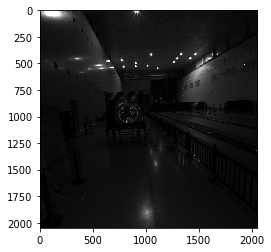

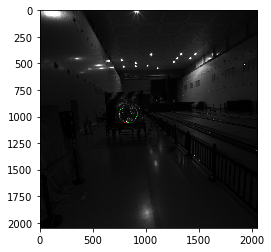

In [13]:
from skimage import io,data,draw,color,transform,feature
import cv2
# 三点拟合圆
def xyz_fitCircleFromThreePoints(A, B, C):
    '''
    三点拟合圆形，返回圆中心坐标，圆半径
    rr, cc, R = xyz_getCircleFromThreePoints()
    ---------------
    input:
    A, B, C = [x, y]:x_y坐标下的点
    ---------------
    output:
    x, y, R:圆所在位置，圆半径(x_y坐标下的点)
    ---------------
    '''
    # 先平移到以A为原点
    [x2, y2] = B - A
    [x3, y3] = C - A
    # 如果三点共线，则返回[0,0,0]
    if x2*y3 == y2*x3:
        print('error！：三点共线')
        return 0, 0, 0
    # 计算圆中心，半径
    x0 = .5*(y3*(x2**2+y2**2) - y2*(x3**2+y3**2))/(x2*y3 - y2*x3)
    y0 = .5*(x2*(x3**2+y3**2) - x3*(x2**2+y2**2))/(x2*y3 - y2*x3)
    R = np.sqrt(x0**2+y0**2)
    # 恢复到原始坐标系
    x0 += A[0]
    y0 += A[1]
    return x0, y0, R
# 1、读入灰度图片
img = io.imread('C3.bmp')
imgShow = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
imgShow[:, :, 0] = img
imgShow[:, :, 1] = img
imgShow[:, :, 2] = img
plt.figure('origin image')
plt.imshow(imgShow)
# 2、手动标定图像中的内外圆 
# x-y坐标系下
C1 = np.array([[760, 918],
               [905, 928],
               [834, 1064]])
C2 = np.array([[766, 921],
               [900, 934],
               [834, 1057]])
# 获得粗手动匹配的内外圆
xc1, yc1, R = xyz_fitCircleFromThreePoints(C1[0, :], C1[1, :], C1[2, :])
xc2, yc2, r = xyz_fitCircleFromThreePoints(C2[0, :], C2[1, :], C2[2, :])
circle1 = [xc1, yc1, R]
circle2 = [xc2, yc2, r]
# plt手动匹配的内外圆
imgShowTmp = imgShow.copy()
cy1, cx1 = draw.circle_perimeter(int(yc1), int(xc1), int(R))
imgShowTmp[cy1, cx1] = [255, 0, 0]
imgShowTmp[int(yc1), int(xc1)] = [255, 0, 0]
cy2, cx2 = draw.circle_perimeter(int(yc2), int(xc2), int(r))
imgShowTmp[cy2, cx2] = [0, 255, 0]
imgShowTmp[int(yc2), int(xc2)] = [0, 255, 0]
plt.figure('手动标记内外圆')
plt.imshow(imgShowTmp)
plt.show()

### def亚像素级校准

In [19]:
# 3、对于手动标记的圆，进行亚像素级精度校准
# img, yc, xc, R
def xyz_SubpixelGaussianCalibration(img, ellipse, pointNum=1000, n=6, plot_flag=False):
    '''
    x, y = xyz_SubpixelGaussianCalibration()
    -----------------
    input:
    img:np.array:height*width:gray
    circle:[xe, ye, a, b, phi]
    pointNum:点数
    -----------------
    output:
    x, y:亚像素级坐标
    -----------------
    '''
    # 求解方程，交点，已知y，求解x
    def fx(y, x0, y0, theta):
        if theta==pi/2 or theta==pi*3/2:
            return np.zeros_like(y)+x0
        slope = tan(theta) # 斜率
        return [(i-y0)/slope+x0 for i in y]
    # 求解方程，交点，已知x，求解y
    def fy(x, x0, y0, theta):
        slope = tan(theta) # 斜率
        return [slope*(i-x0)+y0 for i in x]
    # 最小二乘法求解参数
    from scipy.optimize import leastsq
    def xyz_leastSQ_fitGaussian(x, y):#使用最小二乘，确定系数
        '''
        # [b0, b1, b2]*[1, x, x^2] = y
        # b0 = ln(ymax)-xmax/s
        # b1 = 2*xmax/s
        # b2 = -1/s
        '''
        Y = np.log(y)
        x = np.array(x)
        # 需要拟合的函数
        def fit_func(p, x):
            b0, b1, b2 = p
            return b0+b1*x+b2*(x**2)
        # 误差函数
        def error(p, x, Y):
            return fit_func(p, x) - Y
        p0 = [0, 0, 0]
        paras = leastsq(error, p0, args=(x, Y))
        [b0, b1, b2] = paras[0][:]
        s = -1/b2
        xmax = b1*s/2
        ymax = np.exp(b0+xmax/s)
        return [xmax, ymax, s]
    def xyz_svd_fitGaussian(x, y):#使用svd分解求解线性方程组
        x = np.array(x)
        y = np.array(y)
        A = np.zeros((len(x), 3))
        A[:, 0] = 1
        A[:, 1] = x
        A[:, 2] = x**2
        b = np.log(y)
        [U, s, V] = np.linalg.svd(A)
        # svd(A) = USV'，令X=V'x，B=U'b，则有SX=B,由于S是对角阵，可轻易求出X，又由于V是正交阵，则x=VX，故而方程组得以解出。
        # 由于python中numpy.linalg.svd分解[u,s,v]v为V.T
        # 求解齐次线性方程组，解为svd分解V中的最后一列：svd(A)=USV', Ax=0, USV'*V[:, end]=0
        S = np.zeros((U.shape[1], s.shape[0]))
        s = np.diag(s)
        S[:s.shape[0], :s.shape[0]] = s
        B = np.dot(U.T, b)
        X = np.dot(np.linalg.inv(s), B[:A.shape[1]])
        x = np.dot(V.T, X)
        [b0, b1, b2] = x
        s = -1/b2
        xmax = b1*s/2
        ymax = np.exp(b0+xmax/s)
        return [xmax, ymax, s]  
    
    height, width = img.shape
    xe, ye, a, b, phi = ellipse 
    thetaList = np.arange(0, 2*pi, 2*pi/pointNum)
    pointsList = []
    for theta in thetaList:
        # 获得交点
        # 当认为是圆模型时
        # P = [cos(theta)*R+xc, sin(theta)*R+yc]
        # 当认为是椭圆模型时
        P = [a*cos(phi)*cos(theta)-b*sin(phi)*sin(theta)+xe, \
             a*sin(phi)*cos(theta)+b*cos(phi)*sin(theta)+ye]
        # 在theta这一点的梯度的斜率为
        if ((a*cos(phi)*cos(theta)-b*sin(phi)*sin(theta))*(cos(phi)/a**2-sin(phi)/b**2))==0:
            theta = pi/2
        else:
            k_tan_theta = ((a*sin(phi)*cos(theta)+b*cos(phi)*sin(theta))*(sin(phi)/a**2+cos(phi)/b**2))/\
                          ((a*cos(phi)*cos(theta)-b*sin(phi)*sin(theta))*(cos(phi)/a**2-sin(phi)/b**2))
            theta = np.arctan(k_tan_theta)
        # 求得斜率为tan(theta)， 与P临近的n=12点
        n = n
        if np.abs(tan(theta))>1:# y整数变化
            y0 = int(P[1])
            # 如果theta=pi/4 or theta=pi*5/4
            y = [y0+i-n/2 for i in range(n+1)]
            y[n//2] = P[1]
            x = fx(y, P[0], P[1], theta)
            # y3 = int(P[1])
            # y0, y1, y2, y4, y5, y6 = y3-3, y3-2, y3-1, y3+1, y3+2, y3+3
            # x0, x1, x2, x4, x5, x6 = fx([y0, y1, y2, y4, y5, y6],P[0], P[1], theta)
        else:# x整数变化
            x0 = int(P[0])
            x = [x0+i-n/2 for i in range(n+1)]
            x[n//2] = P[0]
            y = fy(x, P[0], P[1], theta)
            #x3 = int(P[0])
            #x0, x1, x2, x4, x5, x6 = x3-3,  x3-2, x3-1, x3+1, x3+2, x3+3
            #y0, y1, y2, y4, y5, y6 = fy([x0, x1, x2, x4, x5, x6], P[0], P[1], theta)
        #P = np.array([[x0, y0],
        #              [x1, y1],
        #              [x2, y2],
        #              [P[0], P[1]],
        #              [x4, y4],
        #              [x5, y5],
        #              [x6, y6]])
        P = np.zeros((len(x), 2))
        P[:, 0] = x
        P[:, 1] = y
        # 插值
        # int(-1.2)=-1, int(1.8)=1 向中心取整
        # if abs(k)<1
        grayVal = []
        if plot_flag:
            print('theta:',theta*180/pi)
            print('n points:', P)
        #九点法插值
        _P = np.array(P) + [0.5, 0.5]
        for x, y in _P:
            # 判断是否越界
            x0, y0 = int(x), int(y)
            if 0<x0<width-1 and 0<y0<height-1:
                xx1, xx8, xx7 = [x0-1, y0-1], [x0-1, y0], [x0-1, y0+1] 
                xx2, xx0, xx6 = [x0  , y0-1], [x0  , y0], [x0  , y0+1] 
                xx3, xx4, xx5 = [x0+1, y0-1], [x0+1, y0], [x0+1, y0+1] 
                pos = np.array([xx0, xx1, xx2, xx3, xx4, xx5, xx6, xx7, xx8])
                weight = np.array([1/np.linalg.norm(i-[x,y],2) for i in pos])
                weight = weight/weight.sum()
                gray = np.dot(weight, [img[i[1], i[0]] for i in pos])
                #print(sum(weight))
                if plot_flag:
                    print([img[i[1], i[0]] for i in pos])
                    print(weight)
                    print(gray)
                grayVal.append(gray)
        #if np.abs(tan(theta))>1:#刘老师的插值方式，感觉效果不好
        #    for i in range(P.shape[0]):
        #        if i!=n//2:
        #            x1 = int(P[i, 0])
        #            x2 = x1 + 1
        #            y = int(P[i, 1])
        #            lamda = P[i, 0] - x1
        #            if 0<=x1<width and 0<=x2<width and 0<=y<height:
        #                grayL, grayR = img[y, x1], img[y, x2]
        #                grayVal.append((1-lamda)*grayL + lamda*grayR)
        #                print(P[i], grayL, grayR, 1-lamda, lamda)
        #        else:
        #            x1, y1 = int(P[i, 0]), int(P[i, 1])
        #            x2, y2 = x1+1, y1+1
        #            lamda1, lamda2 = P[i, 0]-x1, P[i, 1]-y1
        #            if 0<=x1<width and 0<=x2<width and 0<=y1<height and 0<=y2<height:
        #                grayLU = img[y2, x1]
        #                grayLD = img[y1, x1]
        #                grayRU = img[y2, x2]
        #                grayRD = img[y1, x2]
        #                lamdaLU = (1-lamda1)*(1-lamda2)
        #                lamdaLD = (1-lamda1)*lamda2
        #                lamdaRU = lamda1*(1-lamda2)
        #                lamdaRD = lamda1*lamda2
        #                grayVal.append(grayLU*lamdaLU+grayLD*lamdaLD+grayRU*lamdaRU+grayRD*lamdaRD)
        #                print(P[i], grayLU, grayLD, grayRU, grayRD)
        #                print(P[i], lamdaLU, lamdaLD, lamdaRU, lamdaRD)
        #            else:
        #                continue
        #else:
        #     for i in range(P.shape[0]):
        #        if i!=n//2:
        #            y1 = int(P[i, 1])
        #            y2 = y1 + 1
        #            x = int(P[i, 0])
        #            lamda = P[i, 1] - y1
        #            if 0<=y1<height and 0<=y2<height and 0<=x<width:
        #                grayU, grayD = img[y2, x], img[y1, x]
        #                grayVal.append(lamda*grayU + (1-lamda)*grayD)
        #                print(P[i], grayU, grayD, lamda, 1-lamda)
        #        else:
        #            x1, y1 = int(P[i, 0]), int(P[i, 1])
        #            x2, y2 = x1+1, y1+1
        #            lamda1, lamda2 = P[i, 0]-x1, P[i, 1]-y1
        #            if 0<=x1<width and 0<=x2<width and 0<=y1<height and 0<=y2<height:
        #                grayLU = img[y2, x1]
        #                grayLD = img[y1, x1]
        #                grayRU = img[y2, x2]
        #                grayRD = img[y1, x2]
        #                lamdaLU = (1-lamda1)*lamda2
        #                lamdaLD = (1-lamda1)*(1-lamda2)
        #                lamdaRU = lamda1*lamda2
        #                lamdaRD = lamda1*(1-lamda2)
        #                grayVal.append(grayLU*lamdaLU+grayLD*lamdaLD+grayRU*lamdaRU+grayRD*lamdaRD)
        #                print(P[i], grayLU, grayLD, grayRU, grayRD)
        #                print(P[i], lamdaLU, lamdaLD, lamdaRU, lamdaRD)
        #            else:
        #                continue
        # 拟合高斯模型
        # grayVal, 
        # 计算灰度差
        if plot_flag:
            print('-------------------------------------')
        f = [(np.abs(grayVal[i-1]-grayVal[i])/2 + np.abs(grayVal[i]-grayVal[i+1])/2)/255 for i in range(1, n)]
        # f1 = (np.abs(grayVal[0]-grayVal[1])/2 + np.abs(grayVal[1]-grayVal[2])/2)
        # f2 = (np.abs(grayVal[1]-grayVal[2])/2 + np.abs(grayVal[2]-grayVal[3])/2)
        # f3 = (np.abs(grayVal[2]-grayVal[3])/2 + np.abs(grayVal[3]-grayVal[4])/2)
        # f4 = (np.abs(grayVal[3]-grayVal[4])/2 + np.abs(grayVal[4]-grayVal[5])/2)
        # f5 = (np.abs(grayVal[4]-grayVal[5])/2 + np.abs(grayVal[5]-grayVal[6])/2)
        # 计算距离
        l = [np.linalg.norm(P[i,:]-P[n//2,:], 2) for i in range(1, n)]
        l = [-l[i] if i<n//2-1 else l[i] for i in range(len(l))]
        # l1 = -np.linalg.norm(P[1,:]-P[3,:], 2)
        # l2 = -np.linalg.norm(P[2,:]-P[3,:], 2)
        # l3 = np.linalg.norm(P[3,:]-P[3,:], 2)
        # l4 = np.linalg.norm(P[4,:]-P[3,:], 2)
        # l5 = np.linalg.norm(P[5,:]-P[3,:], 2)
        # 高斯建模
        #print(f1, f2, f3, f4, f5)
        #print(l1, l2, l3, l4, l5)
        x = l
        y = f
        #x = [l1, l2, l3, l4, l5]
        #y = [f1, f2, f3, f4, f5]
        flag = 1
        for i in y:
            if np.abs(i)<1e-10:#灰度差如果变化很小，舍弃该点
                flag=0
                break
        if flag==0:
            continue
        #[xmax, ymax, s] = xyz_leastSQ_fitGaussian(x, y)
        [xmax, ymax, s] = xyz_svd_fitGaussian(x, y)
        if np.abs(s)<1e-10:
            continue
        if xmax<l[0] and xmax>l[-1]:
            continue
        if plot_flag:
            #x = np.arange(l1-1, l5+1, (l5-l1+2)/200)
            #y = ymax*np.exp(-(x-xmax)**2/s)
            x = np.arange(l[0]-1, l[-1]+1, (l[-1]-l[0]+2)/200)
            y = ymax*np.exp(-(x-xmax)**2/s)
            plt.figure()
            plt.plot(x, y, label='gaussian')
            for i in range(len(l)):
                plt.plot(l[i], f[i], 'o', label=str(i))
            # plt.plot(l1, f1, 'o', label='A')
            # plt.plot(l2, f2, 'o', label='B')
            # plt.plot(l3, f3, 'ko', label='O')
            # plt.plot(l4, f4, 'o', label='C')
            # plt.plot(l5, f5, 'o', label='D')
            plt.plot(xmax, ymax, 'r*', label='max')
            plt.legend(loc=1)
            
            plt.figure()
            x, y = xyz_getEllipse(xe, ye, a, b, phi)
            plt.imshow(img)
            #plt.plot(P[:, 0], P[:, 1], 'ro', label='line')
            for i in range(len(P)):
                plt.plot(P[i, 0], P[i, 1], 'o', label=str(i-1))
            plt.plot(P[n//2, 0] + xmax*cos(theta), P[n//2, 1] + xmax*sin(theta), 'wo', label='max')
            plt.plot(x, y, label='ellipse')
            plt.axis('equal')
            plt.axis([710, 920, 1070, 870])
            plt.legend(loc=1)
            
        xcalib = P[n//2, 0] + xmax*cos(theta)
        ycalib = P[n//2, 1] + xmax*sin(theta)    
        pointsList.append([xcalib, ycalib])
    pointsList = np.array(pointsList)
    return pointsList[:, 0], pointsList[:, 1]

In [25]:
xyz_SubpixelGaussianCalibration(img, [xc1, yc1, R, R, 0], pointNum=6, plot_flag=1)
plt.show()

theta: 0.0
n points: [[ 915.          974.81815957]
 [ 916.          974.81815957]
 [ 917.          974.81815957]
 [ 918.25238126  974.81815957]
 [ 919.          974.81815957]
 [ 920.          974.81815957]
 [ 921.          974.81815957]]
[72, 72, 71, 69, 67, 64, 70, 71, 68]
[ 0.18919523  0.05615009  0.07953252  0.07953252  0.18919523  0.13261072
  0.13261072  0.06804963  0.07312335]
69.0492435819
[67, 71, 69, 58, 58, 56, 64, 70, 72]
[ 0.18919523  0.05615009  0.07953252  0.07953252  0.18919523  0.13261072
  0.13261072  0.06804963  0.07312335]
63.6783312292
[58, 69, 58, 44, 43, 41, 56, 64, 67]
[ 0.18919523  0.05615009  0.07953252  0.07953252  0.18919523  0.13261072
  0.13261072  0.06804963  0.07312335]
53.2130715027
[43, 58, 44, 24, 22, 22, 41, 56, 58]
[ 0.13569052  0.05054887  0.0730307   0.08264421  0.27493511  0.15280122
  0.10916543  0.05894819  0.06223576]
34.7600930363
[22, 44, 24, 12, 13, 12, 22, 41, 43]
[ 0.18919523  0.05615009  0.07953252  0.07953252  0.18919523  0.13261072
  0

In [109]:
xyz_SubpixelGaussianCalibration(img, [xc2, yc2, r, r, 0], pointNum=6, plot_flag=1)
plt.show()

In [313]:
xcalib1, ycalib1 = xyz_SubpixelGaussianCalibration(img, [xc1, yc1, R, R, 0])
x1, y1 = xyz_getCircle(xc1, yc1, R)
xcalib2, ycalib2 = xyz_SubpixelGaussianCalibration(img, [xc2, yc2, r, r, 0])
x2, y2 = xyz_getCircle(xc2, yc2, r)
plt.figure('calibration')
plt.plot(x1, y1, 'r', label='R')
plt.plot(x2, y2, 'b', label='r')
plt.plot(xcalib1, ycalib1, '.', label='Rcalib')
plt.plot(xcalib2, ycalib2, '.', label='rcalib')
plt.legend(loc=1)
plt.show()

## 曲率滤波

### 三点计算圆

In [218]:
# 两种方式一致，三点计算圆
pcalib1 = np.zeros((len(xcalib1), 2))
pcalib1[:, 0] = xcalib1
pcalib1[:, 1] = ycalib1
print(xyz_fitCircleFromThreePoints(pcalib1[0], pcalib1[1], pcalib1[2]))

(822.73670696105535, 974.01781768128228, 95.516704650247888)


In [220]:
x1, y1 = pcalib1[0]
x2, y2 = pcalib1[1]
x3, y3 = pcalib1[2]
x0 = .5*((x1+x2)*(x2-x1)*(y3-y2) - (x2+x3)*(x3-x2)*(y2-y1) + (y1-y3)*(y2-y1)*(y3-y2))/\
        ((x2-x1)*(y3-y2) - (x3-x2)*(y2-y1))
y0 = .5*((y1+y2)*(y2-y1)*(x3-x2) - (y2+y3)*(y3-y2)*(x2-x1) + (x1-x3)*(x2-x1)*(x3-x2))/\
        ((y2-y1)*(x3-x2) - (y3-y2)*(x2-x1))
print(x0, y0)

822.736706961 974.017817681


### def曲率滤波函数

In [10]:
def xyz_curvatureFilter(P, ellipse):
    '''
    P = xyz_curvatureFilter()
    -----------------
    input:
    -----------------
    output:
    -----------------
    '''
    def cross(a, b, c):
        # ab x ac 
        # 求得角为∠bac，其sin值的正负性
        x1 = (b[0] - a[0])
        y1 = (b[1] - a[1])
        x2 = (c[0] - a[0])
        y2 = (c[1] - a[1])
        return (x1*y2 - x2*y1)/np.sqrt((x1**2+y1**2)*(x2**2+y2**2))
    xe, ye, a, b, phi = ellipse
    m, n = P.shape
    if m<3:
        return P
    kList = []
    # 计算曲率
    for i in range(m):
        _, _, R = xyz_fitCircleFromThreePoints(P[(i-1)%m], P[i], P[(i+1)%m])
        kList.append(1/R)
    innerP = []
    # 剔除异常点
    for i in range(m):
        if kList[(i-1)%m]<kList[i]>kList[(i+1)%m]:
            continue
            #pass
        theta = np.arcsin(cross([xe, ye], [xe+1, ye], P[i]))
        ex = a*cos(phi)*cos(theta) - b*sin(phi)*sin(theta)
        ey = a*sin(phi)*cos(theta) + b*cos(phi)*sin(theta)
        r = np.linalg.norm([ex, ey], 2)
        if 0.9*r<np.linalg.norm(P[i]-[xe, ye],2)<1.1*r:#剔除异常点
            innerP.append(P[i])
    return np.array(innerP)

### def点排序

In [11]:
def xyz_sortPoints(points, ellipse, plot_flag=False):
    def cross(a, b, c):
        # ab x ac 
        # 求得角为∠bac，其sin值的正负性
        x1 = (b[0] - a[0])
        y1 = (b[1] - a[1])
        x2 = (c[0] - a[0])
        y2 = (c[1] - a[1])
        return (x1*y2 - x2*y1)
    # index_min, index_max = np.argmin(points[:, 0]), np.argmax(points[:, 0])
    # p1, p2 = points[index_min], points[index_max]
    [xe, ye, a, b, phi] = ellipse
    _, _, p1, p2 = xyz_getExtremumFromEllipse(xe, ye, a, b, phi)
    points1 = []
    points2 = []
    for p in points:
        # 如果∠pp1p2为[0, pi]，sin值大于0
        if cross(p1, p2, p)>0:
            points1.append(p)
        else:
            points2.append(p)
    points1 = sorted(points1, key=lambda p: p[0])# x坐标从小到大排序
    points2 = sorted(points2, key=lambda p: p[0], reverse=True)# x坐标从大到小排序
    if plot_flag:
        plt.figure()
        points1 = np.array(points1)
        points2 = np.array(points2)
        plt.plot([p1[0], p2[0]], [p1[1], p2[1]])
        plt.plot(points1[:, 0], points1[:, 1], 'r.')
        plt.plot(points2[:, 0], points2[:, 1], 'b.')
        plt.axis('equal')
    return np.vstack((points1, points2))

### 滤波

In [316]:
xc, yc, r = circle1
ellipse1 = [xc, yc, r, r, 0]
xc, yc, r = circle2
ellipse2 = [xc, yc, r, r, 0]
xcalib1, ycalib1 = xyz_SubpixelGaussianCalibration(img, ellipse1)
x1, y1 = xyz_getEllipse(xc1, yc1, R, R, 0)
xcalib2, ycalib2 = xyz_SubpixelGaussianCalibration(img, ellipse2)
x2, y2 = xyz_getEllipse(xc2, yc2, r, r, 0)
plt.figure('calibration {}'.format(len(xcalib1)))
plt.plot(x1, y1, 'r', label='R')
plt.plot(x2, y2, 'b', label='r')
plt.plot(xcalib1, ycalib1, '.', label='Rcalib')
plt.plot(xcalib2, ycalib2, '.', label='rcalib')
plt.legend(loc=1)

pcalib1 = np.zeros((len(xcalib1), 2))
pcalib1[:, 0] = xcalib1
pcalib1[:, 1] = ycalib1

pcalib1 = xyz_sortPoints(pcalib1, ellipse1)
pCFcalib1 = xyz_curvatureFilter(pcalib1, ellipse1)
#pCFcalib1 = xyz_curvatureFilter(pCFcalib1, circle1)
#pCFcalib1 = xyz_curvatureFilter(pCFcalib1, circle1)
#pCFcalib1 = xyz_curvatureFilter(pCFcalib1, circle1)
xcalib1, ycalib1 = pCFcalib1[:, 0], pCFcalib1[:, 1]


pcalib2 = np.zeros((len(xcalib2), 2))
pcalib2[:, 0] = xcalib2
pcalib2[:, 1] = ycalib2

pcalib2 = xyz_sortPoints(pcalib2, ellipse2)
pCFcalib2 = xyz_curvatureFilter(pcalib2, ellipse2)
#pCFcalib2 = xyz_curvatureFilter(pCFcalib2, circle2)
#pCFcalib2 = xyz_curvatureFilter(pCFcalib2, circle2)
#pCFcalib2 = xyz_curvatureFilter(pCFcalib2, circle2)
xcalib2, ycalib2 = pCFcalib2[:, 0], pCFcalib2[:, 1]

plt.figure('curvatureFilter {}'.format(len(xcalib1)))
plt.plot(x1, y1, 'r', label='R')
plt.plot(x2, y2, 'b', label='r')
plt.plot(xcalib1, ycalib1, '.', label='Rcalib')
plt.plot(xcalib2, ycalib2, '.', label='rcalib')
plt.legend(loc=1)
plt.axis('equal')
plt.show()

### 滤波后拟合结果

In [317]:
#[xc, yc, r] = circle1
#xe, ye, a, b, phi = xc, yc, r, r, 0
#Ay, By, Ax, Bx = xyz_getExtremumFromEllipse(xe, ye, r, r, 0)
#plot结果
imgShow = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
imgShow[:,:,0] = img
imgShow[:,:,1] = img
imgShow[:,:,2] = img
plt.imshow(imgShow)
[xe, ye], [a, b], phi = xyz_fitEllipse(xcalib1, ycalib1)
x, y = xyz_getEllipse(xe, ye, a/2, b/2, phi)
plt.plot(x, y, label='ellipse1')
[xe, ye], [a, b], phi = xyz_fitEllipse(xcalib2, ycalib2)
x, y = xyz_getEllipse(xe, ye, a/2, b/2, phi)
plt.plot(x, y, label='ellipse2')
plt.plot(x1, y1, 'w', label='R')
plt.plot(x2, y2, 'w', label='r')
plt.legend(loc=1)
#for x in range(int(Ax[0])-10, int(Bx[0])+10, 5):
#    for y in range(int(Ay[1]-10), int(By[1]+10),5):
#        plt.plot(x, y, '.', color=colors.rgb2hex((img[y,x]/255, img[y,x]/255, img[y,x]/255)))
plt.axis('equal')
plt.show()

## 多次亚像素级配准+曲率滤波

### 获得粗配准（先以圆为模型粗估计）

In [71]:
from skimage import io,data,draw,color,transform,feature
import cv2
plt.switch_backend('Qt5Agg')
# 三点拟合圆
def xyz_fitCircleFromThreePoints(A, B, C):
    '''
    三点拟合圆形，返回圆中心坐标，圆半径
    rr, cc, R = xyz_getCircleFromThreePoints()
    ---------------
    input:
    A, B, C = [x, y]:x_y坐标下的点
    ---------------
    output:
    x, y, R:圆所在位置，圆半径(x_y坐标下的点)
    ---------------
    '''
    # 先平移到以A为原点
    [x2, y2] = B - A
    [x3, y3] = C - A
    # 如果三点共线，则返回[0,0,0]
    if x2*y3 == y2*x3:
        print('error！：三点共线')
        return 0, 0, 0
    # 计算圆中心，半径
    x0 = .5*(y3*(x2**2+y2**2) - y2*(x3**2+y3**2))/(x2*y3 - y2*x3)
    y0 = .5*(x2*(x3**2+y3**2) - x3*(x2**2+y2**2))/(x2*y3 - y2*x3)
    R = np.sqrt(x0**2+y0**2)
    # 恢复到原始坐标系
    x0 += A[0]
    y0 += A[1]
    return x0, y0, R
# 1、读入灰度图片
img = io.imread('./2-10m/5m/C3.bmp')
imgShow = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
imgShow[:, :, 0] = img
imgShow[:, :, 1] = img
imgShow[:, :, 2] = img
plt.figure('origin image')
plt.imshow(imgShow)
# 2、手动标定图像中的内外圆 
# x-y坐标系下
C2 = np.array([[614, 1085],
               [901, 1113],
               [760, 1326]])
C1 = np.array([[607, 1073],
               [745, 1339],
               [923, 1160]])
# 获得粗手动匹配的内外圆
xc1, yc1, R = xyz_fitCircleFromThreePoints(C1[0, :], C1[1, :], C1[2, :])
xc2, yc2, r = xyz_fitCircleFromThreePoints(C2[0, :], C2[1, :], C2[2, :])
Ellipse1 = [xc1, yc1, R, R, 0]
Ellipse2 = [xc2, yc2, r, r, 0]
# plt手动匹配的内外圆
imgShowTmp = imgShow.copy()
#cy1, cx1 = draw.circle_perimeter(int(yc1), int(xc1), int(R))
#imgShowTmp[cy1, cx1] = [255, 0, 0]
#imgShowTmp[int(yc1), int(xc1)] = [255, 0, 0]
#cy2, cx2 = draw.circle_perimeter(int(yc2), int(xc2), int(r))
#imgShowTmp[cy2, cx2] = [0, 255, 0]
#imgShowTmp[int(yc2), int(xc2)] = [0, 255, 0]
plt.figure('手动标记内外圆')
plt.imshow(imgShowTmp)
x1, y1 = xyz_getEllipse(xc1, yc1, R, R, 0)
x2, y2 = xyz_getEllipse(xc1, yc1, r, r, 0)
plt.plot(x1, y1, 'r', label='R')
plt.plot(x2, y2, 'b', label='r')
plt.legend()
plt.show()

### 迭代获得精确拟合椭圆

In [76]:
plt.switch_backend('Qt5Agg')
def xyz_SubpixelIter_GC_CF_Ellipse(img, Ellipse1, iterNum=10, n=6, plot_flag=False):
    '''
    '''
    # 粗配准椭圆
    ellipse1 = Ellipse1
    #ellipse2 = Ellipse2

    # 显示未配准前的椭圆
    imgShow = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    imgShow[:,:,0] = img
    imgShow[:,:,1] = img
    imgShow[:,:,2] = img
    if plot_flag:
        plt.figure('Iteration')
        plt.imshow(imgShow)
        xe, ye, a, b, phi = ellipse1
        x1, y1 = xyz_getEllipse(xe, ye, a, b, phi)
        #xe, ye, a, b, phi = ellipse2
        #x2, y2 = xyz_getEllipse(xe, ye, a, b, phi)
        plt.plot(x1, y1, 'w', label='o_befor')
        #plt.plot(x2, y2, 'w', label='i_befor')
        #plt.axis([710, 920, 1070, 870])
        Ay, By, Ax, Bx = xyz_getExtremumFromEllipse(xe, ye, a, b, phi)
        plt.axis([Ax[0]*0.9, Bx[0]*1.1, Ay[1]*0.9, By[1]*1.1])
        plt.legend()

    e_List1 = [ellipse1]
    #e_List2 = [ellipse2]
    for i in range(iterNum):
        [xe, ye, a, b, phi] = ellipse1
        xx, yy = xyz_getEllipse(xe, ye, a, b, phi)
        # (迭代)
        # 高斯模型获得峰值亚像素点
        x1, y1 = xyz_SubpixelGaussianCalibration(img, ellipse1, pointNum=500, n=n)
        #x2, y2 = xyz_SubpixelGaussianCalibration(img, ellipse2)
        if 0:
            plt.figure('calibration_{}'.format(str(i)))
            plt.imshow(imgShow)
            plt.plot(x1, y1, 'r.', label='Rcalib')
            #plt.plot(x2, y2, 'b.', label='rcalib')
            plt.legend(loc=1)
            plt.axis('equal')
            #plt.axis([710, 920, 1070, 870])
            Ay, By, Ax, Bx = xyz_getExtremumFromEllipse(xe, ye, a, b, phi)
            plt.axis([Ax[0]*0.9, Bx[0]*1.1, Ay[1]*0.9, By[1]*1.1])

        # 曲率滤波
        P1 = np.zeros((x1.shape[0], 2))
        P1[:, 0] = x1
        P1[:, 1] = y1
        #P1 = xyz_sortPoints(P1, ellipse1, plot_flag=0)
        # 滤波两次，感觉有些点没有滤掉
        P1 = xyz_curvatureFilter(P1, ellipse1)
        #P1 = xyz_curvatureFilter(P1, ellipse1)
        xcalib1 = P1[:, 0]
        ycalib1 = P1[:, 1]

        #P2 = np.zeros((x2.shape[0], 2))
        #P2[:, 0] = x2
        #P2[:, 1] = y2
        #P2 = xyz_sortPoints(P2, ellipse2, plot_flag=1)
        #P2 = xyz_curvatureFilter(P2, ellipse2)
        #xcalib2 = P2[:, 0]
        #ycalib2 = P2[:, 1]
        if 0:
            plt.figure('calibration_and_filter_{}'.format(str(i)))
            plt.imshow(imgShow)
            plt.plot(xx, yy, 'b', label='last fit ellipse')
            plt.plot(xcalib1, ycalib1, 'r.', label='Rcalib')
            #plt.plot(xcalib2, ycalib2, 'b.', label='rcalib')
            plt.legend(loc=1)
            plt.axis('equal')
            #plt.axis([710, 920, 1070, 870])
            Ay, By, Ax, Bx = xyz_getExtremumFromEllipse(xe, ye, a, b, phi)
            plt.axis([Ax[0]*0.9, Bx[0]*1.1, Ay[1]*0.9, By[1]*1.1])
        # 重新拟合椭圆
        [xe, ye], [a, b], phi = xyz_fitEllipse(xcalib1, ycalib1)
        ellipse1 = [xe, ye, a/2, b/2, phi]
        e_List1.append(ellipse1)
        
        #print('iter is {},\nlast ellipse is\n{},\ncurrent ellipse is\n{}'.format(i, e_List1[i], e_List1[i+1]))
        e1 = e_List1[i]
        e2 = e_List1[i+1]
        #emax = [e1[i] if np.abs(e1[i])>np.abs(e2[i]) else e2[i] for i in range(5)]
        emax = e_List1[0]
        emax[4] = pi
        e1 = np.divide(e1, emax)
        e2 = np.divide(e2, emax)
        print(i)
        print('distance of two ellipse after normlization is {}'.format(np.linalg.norm(e1-e2, 2)))
        #[xe, ye], [a, b], phi = xyz_fitEllipse(xcalib2, ycalib2)
        #ellipse2 = [xe, ye, a/2, b/2, phi]
        #e_List2.append(ellipse2)

    # plot
    if plot_flag:
        plt.figure('result')
        plt.imshow(imgShow)
        for i in range(len(e_List1)):
            [xe, ye, a, b, phi] = e_List1[i]
            x1, y1 = xyz_getEllipse(xe, ye, a, b, phi)
            #[xe, ye, a, b, phi] = e_List2[i]
            #x2, y2 = xyz_getEllipse(xe, ye, a, b, phi)
            # plot结果
            plt.plot(x1, y1, label='ellipse1_{}'.format(str(i)))
            #plt.plot(x2, y2, label='ellipse2_{}'.format(str(i)))
        plt.legend(loc=1)
        plt.axis('equal')
        #plt.axis([710, 920, 1070, 870])
        Ay, By, Ax, Bx = xyz_getExtremumFromEllipse(xe, ye, a, b, phi)
        plt.axis([Ax[0]*0.9, Bx[0]*1.1, Ay[1]*0.9, By[1]*1.1])
    return e_List1[0], e_List1[-1], xcalib1, ycalib1

In [77]:
beforE1, afterE1, xcalib1, ycalib1 = xyz_SubpixelIter_GC_CF_Ellipse(img, Ellipse1, iterNum=5, plot_flag=1)
plt.show()

0
distance of two ellipse after normlization is 0.6972688099613791
1
distance of two ellipse after normlization is 0.7706005090158089
2
distance of two ellipse after normlization is 0.9580195360751383
3
distance of two ellipse after normlization is 0.012450747800122512
4
distance of two ellipse after normlization is 0.00960583754716662


In [80]:
beforE2, afterE2, xcalib2, ycalib2 = xyz_SubpixelIter_GC_CF_Ellipse(img, Ellipse2, iterNum=5, plot_flag=1, n=6)
plt.show()

0
distance of two ellipse after normlization is 0.8712951249387334
1
distance of two ellipse after normlization is 0.013811419645689122
2
distance of two ellipse after normlization is 0.023777544282581123
3
distance of two ellipse after normlization is 0.07176275346744009
4
distance of two ellipse after normlization is 0.14985111130742354


In [81]:
plt.figure()
plt.imshow(imgShow)
[xe, ye, a, b, phi] = beforE1
x, y = xyz_getEllipse(xe, ye, a, b, phi)
plt.plot(x, y, 'w', label='beforE1')
[xe, ye, a, b, phi] = beforE2
x, y = xyz_getEllipse(xe, ye, a, b, phi)
plt.plot(x, y, 'w', label='beforE2')
[xe, ye, a, b, phi] = afterE1
x, y = xyz_getEllipse(xe, ye, a, b, phi)
plt.plot(x, y, 'r', label='afterE1')
plt.plot(xcalib1, ycalib1, 'r.', label='calib1')
[xe, ye, a, b, phi] = afterE2
x, y = xyz_getEllipse(xe, ye, a, b, phi)
plt.plot(x, y, 'b', label='afterE2')
plt.plot(xcalib2, ycalib2, 'b.', label='calib2')
plt.legend(loc=1)
Ay, By, Ax, Bx = xyz_getExtremumFromEllipse(xe, ye, a, b, phi)
plt.axis([Ax[0]*0.9, Bx[0]*1.1, Ay[1]*0.9, By[1]*1.1])
plt.show()

- 九点插值：效果貌似好些
    - 高斯建模求极值点，剔除异常点
    - svd求解线性方程组
- 最小二乘拟合椭圆
- 滤波方式：
    - 曲率突变
        - 曲率计算（三点计算圆半径）
        - 点排序
    - 变化过于剧烈的点（太里或者太外）
- 迭代方式：多次迭代

# 确定环位置以及姿态

- 估计环中心投影坐标（交比）
- 环中心周围多少像素假设为投影中心（计算方差，找到方差最小）

- 确定环位置以及位姿：使用外圆计算（由于每一条直线确定的OC长度不一，取均值为OC长）（姿态：计算若干个点，使用最小二乘法，估计所在平面以及对应的法向量）

## def计算位姿

In [26]:
def xyz_CalculatePoseFromEllipse(E1, E2, f=8e-3, du=5.5e-6, dv=5.5e-6, width=2048, height=2048, R=0.654, r=0.597, plot_flag=False, pointsNum=10):
    '''
    -------------------
    E1:外环椭圆
    E2:内环椭圆
    -------------------
    position:
    variance:
    normal:
    -------------------
    '''
    # 最小二乘法求解参数
    from scipy.optimize import leastsq
    def xyz_leastSQ_fitFlat_getNormal(x):#使用最小二乘，确定系数
        '''
        # [b0, b1, b2]*[1, x, x^2] = y
        # b0 = ln(ymax)-xmax/s
        # b1 = 2*xmax/s
        # b2 = -1/s
        '''
        x = np.array(x)
        Y = np.ones(x.shape[0])
        # 需要拟合的函数
        def fit_func(p, x):
            return np.dot(x, p)
        # 误差函数
        def error(p, x, Y):
            return fit_func(p, x) - Y
        p0 = [0, 0, 0]
        paras = leastsq(error, p0, args=(x, Y))
        normal = paras[0][:]
        return normal/np.linalg.norm(normal, 2)
    
    def xyz_svd_fitFlat_getNormal(x):#使用svd分解求解线性方程组
        A = np.array(x)
        b = np.ones(A.shape[0])
        [U, s, V] = np.linalg.svd(A)
        # svd(A) = USV'，令X=V'x，B=U'b，则有SX=B,由于S是对角阵，可轻易求出X，又由于V是正交阵，则x=VX，故而方程组得以解出。
        # 由于python中numpy.linalg.svd分解[u,s,v]v为V.T
        # 求解齐次线性方程组，解为svd分解V中的最后一列：svd(A)=USV', Ax=0, USV'*V[:, end]=0
        S = np.zeros((U.shape[1], s.shape[0]))
        s = np.diag(s)
        S[:s.shape[0], :s.shape[0]] = s
        B = np.dot(U.T, b)
        X = np.dot(np.linalg.inv(s), B[:A.shape[1]])
        x = np.dot(V.T, X)
        return x/np.linalg.norm(x, 2)
    
    #像平面上的椭圆到焦平面上的椭圆
    xe, ye, a, b, phi = E1
    E1 = [(xe-width/2)*du, (ye-height/2)*dv, a*du, b*dv, phi]
    xe, ye, a, b, phi = E2
    E2 = [(xe-width/2)*du, (ye-height/2)*dv, a*du, b*dv, phi]
    #交比获得环中心投影
    [u0, v0] = xyz_calc_ffxcffycFromConcentricCircles(E1, E2, R, r, plot_Flag=plot_flag)
    if plot_flag:
        print('Ring center project center on focal flat:', u0, v0)
    #求解空间圆环位姿
    ff_xc, ff_yc = u0, v0
    radius = R
    [xe, ye, a, b, phi] = E1
    gammaList = np.arange(0, pi, pi/pointsNum)
    positionList = []
    ringPoints = []
    # 求解空间圆上的一点
    # 使用真实的圆投影点进行计算
    for gamma in gammaList:
        [xc1, yc1, zc1], [x1, y1, z1], voa, vob, voc, phi = \
        xyz_calcCircleCenterAndAPoint(ff_xc, ff_yc, xe, ye, a, b, phi, gamma=gamma, f=f, radius=radius,show_message=0)
        positionList.append([xc1, yc1, zc1])
        ringPoints.append([x1, y1, z1])
    # 计算环中心距离方差，平均值，最小二乘法拟合姿态
    position = np.mean(positionList, axis=0)
    variance_position = np.var([np.linalg.norm(pos, 2) for pos in positionList])
    normal1 = xyz_svd_fitFlat_getNormal(ringPoints)
    # normal2 = xyz_leastSQ_fitFlat_getNormal(ringPoints)
    # print('环空间位置：', position)
    # print('环距离方差：', variance_position)
    # print('svd normal：', normal1)
    # print('lsq noraml：', normal2)
    return position, variance_position, normal1

In [82]:
#计算5个点
print(xyz_CalculatePoseFromEllipse(beforE1, beforE2, plot_flag=1, pointsNum=5))
plt.show()

Ring center project center on focal flat: -0.0015087022752804224 0.0007771098712375756
(array([-1.03727984,  0.53428726,  5.50024933]), 0.0024798235839233558, array([ 0.12812984, -0.00979872,  0.99170899]))


In [83]:
#计算10个点
print(xyz_CalculatePoseFromEllipse(beforE1, beforE2, plot_flag=1))
plt.show()

Ring center project center on focal flat: -0.0015087022752804224 0.0007771098712375756
(array([-1.03727984,  0.53428726,  5.50024933]), 0.0024798138580225033, array([ 0.11717955, -0.0562079 ,  0.99151885]))


## 粗配准VS精配准

In [84]:
# 粗配准
print(xyz_CalculatePoseFromEllipse(beforE1, beforE2, plot_flag=1))
print('----------------')
print(xyz_CalculatePoseFromEllipse(afterE1, afterE2, plot_flag=1))
plt.show()

Ring center project center on focal flat: -0.0015087022752804224 0.0007771098712375756
(array([-1.03727984,  0.53428726,  5.50024933]), 0.0024798138580225033, array([ 0.11717955, -0.0562079 ,  0.99151885]))
----------------
Ring center project center on focal flat: -0.0015188216616859687 0.0007559912685837756
(array([-1.03505945,  0.51519933,  5.45190774]), 0.015970220518832654, array([ 0.28338579,  0.29230558,  0.91337284]))


## def在粗估计ff_xc, ff_yc下区域计算

In [61]:
def xyz_CalculatePoseFromEllipse_round\
    (E1, E2, initCenter=None, f=8e-3, du=5.5e-6, dv=5.5e-6, width=2048, height=2048, R=0.654, \
     r=0.597, plot_flag=False, pointsNum=10, pixelsNum=10, step=2):
    '''
    -------------------
    E1:外环椭圆
    E2:内环椭圆
    -------------------
    position:
    variance:
    normal:
    -------------------
    '''
    # 最小二乘法求解参数
    from scipy.optimize import leastsq
    def xyz_leastSQ_fitFlat_getNormal(x):#使用最小二乘，确定系数
        '''
        # [b0, b1, b2]*[1, x, x^2] = y
        # b0 = ln(ymax)-xmax/s
        # b1 = 2*xmax/s
        # b2 = -1/s
        '''
        x = np.array(x)
        Y = np.ones(x.shape[0])
        # 需要拟合的函数
        def fit_func(p, x):
            return np.dot(x, p)
        # 误差函数
        def error(p, x, Y):
            return fit_func(p, x) - Y
        p0 = [0, 0, 0]
        paras = leastsq(error, p0, args=(x, Y))
        normal = paras[0][:]
        return normal/np.linalg.norm(normal, 2)
    
    def xyz_svd_fitFlat_getNormal(x):#使用svd分解求解线性方程组
        A = np.array(x)
        b = np.ones(A.shape[0])
        [U, s, V] = np.linalg.svd(A)
        # svd(A) = USV'，令X=V'x，B=U'b，则有SX=B,由于S是对角阵，可轻易求出X，又由于V是正交阵，则x=VX，故而方程组得以解出。
        # 由于python中numpy.linalg.svd分解[u,s,v]v为V.T
        # 求解齐次线性方程组，解为svd分解V中的最后一列：svd(A)=USV', Ax=0, USV'*V[:, end]=0
        S = np.zeros((U.shape[1], s.shape[0]))
        s = np.diag(s)
        S[:s.shape[0], :s.shape[0]] = s
        B = np.dot(U.T, b)
        X = np.dot(np.linalg.inv(s), B[:A.shape[1]])
        x = np.dot(V.T, X)
        return x/np.linalg.norm(x, 2)
    
    
    #像平面上的椭圆到焦平面上的椭圆
    xe, ye, a, b, phi = E1
    E1 = [(xe-width/2)*du, (ye-height/2)*dv, a*du, b*dv, phi]
    xe, ye, a, b, phi = E2
    E2 = [(xe-width/2)*du, (ye-height/2)*dv, a*du, b*dv, phi]
    
    if initCenter is None:
        #交比获得环中心投影
        [u0, v0] = xyz_calc_ffxcffycFromConcentricCircles(E1, E2, R, r, plot_Flag=plot_flag)
        u0, v0 = u0//du, v0//dv
    else:
        u0, v0 = initCenter[0]-width/2, initCenter[1]-height/2
    
    class u_v_pose_variance():#用作结果保存
        def __init__(self, u0, v0, position, normal, variance):
            self.u0 = u0
            self.v0 = v0
            self.position = position
            self.noraml = normal
            self.variance = variance
            self.color = 0
            
    radius = R
    [xe, ye, a, b, phi] = E1
    pixels = pixelsNum
    step = step
    
    result = []
    for i in np.arange(-pixels, pixels+step, step):
        for j in np.arange(-pixels, pixels+step, step):
            #print(i, j)
            _u0 = i + u0
            _v0 = j + v0
            #求解空间圆环位姿
            ff_xc, ff_yc = _u0*du, _v0*dv
            gammaList = np.arange(0, pi, pi/pointsNum)
            positionList = []
            ringPoints = []
            # 求解空间圆上的一点
            # 使用真实的圆投影点进行计算
            for gamma in gammaList:
                [xc1, yc1, zc1], [x1, y1, z1], voa, vob, voc, phi = \
                xyz_calcCircleCenterAndAPoint(ff_xc, ff_yc, xe, ye, a, b, phi, gamma=gamma, f=f, radius=radius,show_message=0)
                positionList.append([xc1, yc1, zc1])
                ringPoints.append([x1, y1, z1])
            # 计算环中心距离方差，平均值，最小二乘法拟合姿态
            position = np.mean(positionList, axis=0)
            variance_position = np.var([np.linalg.norm(pos, 2) for pos in positionList])
            normal = xyz_svd_fitFlat_getNormal(ringPoints)
            result.append(u_v_pose_variance(_u0+width/2, _v0+height/2, position, normal, variance_position))
    return result, u0+width/2, v0+height/2

In [32]:
import time
from matplotlib import colors

In [85]:
time1 = time.time()
#E1, E2 = beforE1, beforE2
E1, E2 = afterE1, afterE2
iterNum = 0
pointsNum=4
pixelsNum=1
step=1
while True:
    print('--------------')
    print(iterNum)
    if iterNum == 0:
        result, u0, v0 = xyz_CalculatePoseFromEllipse_round(E1, E2, initCenter=None, pointsNum=pointsNum, pixelsNum=pixelsNum, step=step)
    else:
        result, u0, v0 = xyz_CalculatePoseFromEllipse_round(E1, E2, initCenter=[u0, v0], pointsNum=pointsNum, pixelsNum=pixelsNum, step=step)
    print(u0, v0, len(result))
    minVars, maxVars = min(result, key=lambda p: p.variance).variance, max(result, key=lambda p: p.variance).variance
    for p in result:
        if p.variance == minVars:
            _u0, _v0 = p.u0, p.v0
            print(p.u0, p.v0, p.position, p.variance, p.noraml)
    print(time.time() - time1, ' s')
    time1 = time.time()
    if iterNum==9:
        break
    if _u0 == u0 and _v0 == v0 :
        step = step/2
        pixelsNum = pixelsNum/2
        iterNum += 1
        continue
    u0, v0 = _u0, _v0
    # for p in result:
    #     p.color = colors.rgb2hex((0, (p.variance-minVars)/(maxVars-minVars), 0))
    # plt.figure(str(iterNum))
    # for p in result:
    #     plt.plot(p.u0, p.v0, 'o', color=p.color)
    iterNum += 1  

--------------
0
747.0 1161.0 9
748.0 1162.0 [-1.03753802  0.51876901  5.46792107] 0.0128734463821 [ 0.31468369  0.40767472  0.85719047]
22.07326102256775  s
--------------
1
748.0 1162.0 9
749.0 1163.0 [-1.04286355  0.52712012  5.5159725 ] 0.00637276205828 [ 0.21156819  0.33354477  0.91868754]
20.530175924301147  s
--------------
2
749.0 1163.0 9
750.0 1164.0 [-1.04599027  0.53444758  5.55270217] 0.00284137649502 [ 0.10898815  0.26300417  0.958619  ]
20.033457040786743  s
--------------
3
750.0 1164.0 9
751.0 1165.0 [-1.04671214  0.54060957  5.57688787] 0.00126799468969 [ 0.02001017  0.20821424  0.97787853]
20.075894594192505  s
--------------
4
751.0 1165.0 9
751.0 1166.0 [-1.04636216  0.54426163  5.57502315] 0.000654892681011 [-0.00715059  0.1341705   0.99093246]
20.200040102005005  s
--------------
5
751.0 1166.0 9
750.0 1167.0 [-1.04494182  0.54535285  5.54713638] 0.000102147822517 [-0.01088055 -0.00135213  0.99993989]
21.657241106033325  s
--------------
6
750.0 1167.0 9
750.0 11

In [37]:
from matplotlib import colors

In [42]:
# f=0.008, du=5.5e-06, dv=5.5e-06, width=2048, height=2048, R=0.654, r=0.597
print(xyz_calc_ffxcffycFromConcentricCircles(beforE1, beforE2, 0.654, 0.597, plot_Flag=1))
plt.show()

[825.4842299372904, 974.6573360936482]


In [39]:
result = result
minVars, maxVars = min(result, key=lambda p: p.variance).variance, max(result, key=lambda p: p.variance).variance
for p in result:
    p.color = colors.rgb2hex((0, (p.variance-minVars)/(maxVars-minVars), 0))
plt.figure()
for p in result:
    plt.plot(p.u0, p.v0, 'o', color=p.color)
plt.show()

In [180]:
# befor
result = result1
minVars, maxVars = min(result, key=lambda p: p.variance).variance, max(result, key=lambda p: p.variance).variance
for p in result:
    if p.variance == minVars:
        print(p.u0, p.v0, p.position, p.variance, p.noraml)
pc = result[int(len(result)//2 + np.sqrt(len(result))//2)]
print(pc.u0, pc.v0, pc.position, pc.variance, pc.noraml)

829.0 975.0 [ -1.42932167  -0.35916288  10.66160686] 0.000306559446866 [-0.04626102 -0.03356591  0.99836529]
825.0 974.0 [-1.26170315 -0.31701084  9.22213361] 0.852079225231 [ 0.33926496 -0.89985365  0.27415816]


In [182]:
# after
result = result2
minVars, maxVars = min(result, key=lambda p: p.variance).variance, max(result, key=lambda p: p.variance).variance
for p in result:
    if p.variance == minVars:
        print(p.u0, p.v0, p.position, p.variance, p.noraml)
pc = result[int(len(result)//2 + np.sqrt(len(result))//2)]        
print(pc.u0, pc.v0, pc.position, pc.variance, pc.noraml)

828.0 975.0 [ -1.42225307  -0.35556327  10.55475377] 0.00594652059257 [-0.01663531 -0.39034274  0.92051932]
824.0 975.0 [-1.24327527 -0.30460244  9.04200197] 1.05597800312 [ 0.09615615 -0.97851465  0.18238168]


## 实验过程

In [76]:
f=8e-3
du=5.5e-6
dv=5.5e-6
width=2048
height=2048
R = 0.654
r = 0.597

In [77]:
#粗配准估计的椭圆
xe, ye, a, b, phi = beforE1
E1 = [(xe-width/2)*du, (ye-height/2)*dv, a*du, b*dv, phi]
xe, ye, a, b, phi = beforE2
E2 = [(xe-width/2)*du, (ye-height/2)*dv, a*du, b*dv, phi]
[u0, v0] = xyz_calc_ffxcffycFromConcentricCircles(E1, E2, R, r, plot_Flag=1)
print('Ring center project center on focal flat:', u0, v0)
plt.show()

Ring center project center on focal flat: -0.0010918367353449114 -0.0002713846514849342


In [78]:
ff_xc, ff_yc = u0, v0
radius = R
[xe, ye, a, b, phi] = E1
# 求解空间圆上的一点
# 使用真实的圆投影点进行计算
print('-----------------------')
[xc1, yc1, zc1], [x1, y1, z1], voa, vob, voc, phi = \
xyz_calcCircleCenterAndAPoint(ff_xc, ff_yc, xe, ye, a, b, phi, gamma=0, f=f, radius=radius,show_message=0)
[xc2, yc2, zc2], [x2, y2, z2], voa, vob, voc, phi = \
xyz_calcCircleCenterAndAPoint(ff_xc, ff_yc, xe, ye, a, b, phi, gamma=pi/2, f=f, radius=radius,show_message=0)
print("两次计算圆在三维空间中位置: ", [xc1, yc1, zc1], [xc2, yc2, zc2])
print("两次计算圆在三维空间中两点: ", [x1, y1, z1], [x2, y2, z2])
# 计算圆位姿
[x1, y1, z1] = [x1-xc1, y1-yc1, z1-zc1]
[x2, y2, z2] = [x2-xc2, y2-yc2, z2-zc2]
n_cal = np.array([y1*z2-y2*z1, -x1*z2+x2*z1, x1*y2-x2*y1])
n_cal = n_cal/np.linalg.norm(n_cal, 2)
#print(np.dot(np.array([x1,y1,z1]), n_cal))
#print(np.dot(np.array([x2,y2,z2]), n_cal))
#print('error_circle: {}'.format(np.arccos(np.dot(Normal, n_cal))*180/pi))
print('圆位姿： ', n_cal)

-----------------------
两次计算圆在三维空间中位置:  [-1.1601274423014578, -0.28835884653361743, 8.5003730301122218] [-1.4524332044567385, -0.36101375437978861, 10.642127398271972]
两次计算圆在三维空间中两点:  [-0.59417682735871391, -0.27724716362345225, 8.1728177951535699] [-1.4498162861181467, 0.2926998625692902, 10.622952968587569]
圆位姿：  [ 0.50044042  0.0233818   0.86545518]
